In [5]:
import base64
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import shutil
import torch
from torch import distributions, nn
import torch.nn.functional as F
import time
import tqdm

# Custom imports
from graph_nns import GraphNNA3C, SmallFullyConnectedGNNLayer, FullyConnectedGNNLayer
import vectorized_env
from vectorized_env import KaggleMABEnvTorchVectorized
import vectorized_agents as va

%matplotlib inline
jtplot.style()

DEVICE = torch.device('cuda')
OBS_NORM = 100. / 1999.

## A3C RL algorithm

In [6]:
def wrap_model(model):
    def model_wrapped(states):
        return model.sample_action(states.unsqueeze(0)).squeeze(0)
    return model_wrapped


class A3CVectorized():
    def __init__(self, model_constructor, optimizer, model=None, device=torch.device('cuda'), exp_folder=Path('/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP'),
                 play_against_past_selves=True, n_past_selves=4, checkpoint_freq=10, initial_opponent_pool=[], opp_posterior_decay=0.95):
        self.model_constructor = model_constructor
        self.optimizer = optimizer
        if model is None:
            self.model = self.model_constructor()
        else:
            self.model = model
        self.device = device
        self.exp_folder = exp_folder
        if str(self.exp_folder) == '/home/isaiah/GitHub/Kaggle/Santa_2020/runs/TEMP':
            print('WARNING: Using TEMP exp_folder')
            shutil.rmtree(self.exp_folder)
        elif self.exp_folder.exists() and any(Path(self.exp_folder).iterdir()):
            raise RuntimeError(f'Experiment folder {self.exp_folder} already exists and is not empty')
        else:
            print(f'Saving results to {self.exp_folder}')
        self.exp_folder.mkdir(exist_ok=True)
        self.play_against_past_selves = play_against_past_selves
        self.n_past_selves = n_past_selves
        self.checkpoint_freq = checkpoint_freq
        self.initial_opponent_pool = initial_opponent_pool
        self.opp_posterior_decay = opp_posterior_decay
        
        self.env = None
        self.opp_a = np.ones(len(self.initial_opponent_pool))
        self.opp_b = np.ones(len(self.initial_opponent_pool))
        self.checkpoints = []
        self.true_ep_num = 0
        
    def train(self, n_episodes, batch_size=30, gamma=0.9, **env_kwargs):
        if self.play_against_past_selves and 'opponent' in env_kwargs.keys():
            raise RuntimeError('Cannot play against past selves when opponent is defined')
        self.env = None
        self.model.train()
        episode_reward_sums = []
        
        for ep_num in tqdm.trange(n_episodes):
            if self.play_against_past_selves:
                opponents, opponent_idxs = self.sample_opponents()
                self.env = KaggleMABEnvTorchVectorized(opponent=opponents, **env_kwargs)
            else:
                self.env = KaggleMABEnvTorchVectorized(**env_kwargs)
            buffer_s, buffer_a, buffer_r = [], [], []
            s, r, _, _ = self.env.reset()
            episode_reward_sums.append(r)
            step_count = 1
            while not self.env.done:
                # Batch size of 1 for inference
                a = self.model.sample_action(s.to(device=self.device).unsqueeze(0)).squeeze(0)
                next_s, r, done, _ = self.env.step(a)

                buffer_s.append(s)
                buffer_a.append(a)
                buffer_r.append(r)

                if step_count % batch_size == 0 or done:
                    if done:
                        v_next_s = torch.zeros_like(buffer_r[-1])
                    else:
                        _, v_next_s = self.model(next_s.to(device=self.device).unsqueeze(0))
                        v_next_s = v_next_s.detach().squeeze(0)
                    v_next_s.to(device=self.device)

                    buffer_v_target = []
                    for r in buffer_r[::-1]:
                        v_next_s = r + gamma * v_next_s
                        buffer_v_target.append(v_next_s)
                    buffer_v_target.reverse()

                    loss = self.model.loss_func(
                        torch.stack(buffer_s).to(device=self.device),
                        torch.stack(buffer_a).to(device=self.device),
                        torch.stack(buffer_v_target).to(device=self.device)
                    )
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    buffer_s, buffer_a, buffer_r = [], [], []
                s = next_s
                episode_reward_sums[-1] += r
                step_count += 1
            if self.play_against_past_selves:
                if opponent_idxs is not None:
                    self.update_opponent_scores(opponent_idxs, self.env.player_rewards_sums.cpu())
                if ep_num % self.checkpoint_freq == 0:
                    self.checkpoint()
            if ep_num % self.checkpoint_freq == 0:
                self.save()
            episode_reward_sums[-1] = episode_reward_sums[-1].mean() / self.env.r_norm
            self.true_ep_num += 1
        self.save(finished=True)
        return episode_reward_sums
    
    def sample_opponents(self):
        if len(self.initial_opponent_pool) + len(self.checkpoints) == 0:
            print('No opponents sampled')
            return None, None
        else:
            opponents = []
            opponent_idxs = []
            for i in range(self.n_past_selves):
                # Sample opponents randomly if the agent is losing > some fraction of it's games, otherwise use thompson sampling
                if np.sum(self.opp_b - 1) <= np.sum(self.opp_a - 1) / 5.:
                    if i == 0:
                        print('Sampling opponents randomly')
                    selected_opp_idx = np.random.randint(len(self.opp_a))
                else:
                    if i == 0:
                        print('Sampling opponents using Thompson sampling')
                    selected_opp_idx = np.random.beta(self.opp_a, self.opp_b).argmax()
                opponent_idxs.append(selected_opp_idx)
                opponents.append(self.get_opponent(selected_opp_idx))
                if selected_opp_idx < len(self.initial_opponent_pool):
                    try:
                        print(f'Opponent {i}: {opponents[-1].name} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                    except AttributeError:
                        print(f'Opponent {i}: {opponents[-1]} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
                else:
                    print(f'Opponent {i}: Checkpoint #{selected_opp_idx - len(self.initial_opponent_pool)} with alpha {self.opp_a[selected_opp_idx]:.2f} and beta {self.opp_b[selected_opp_idx]:.2f}')
            print()
            return va.MultiAgent(opponents), opponent_idxs

    def update_opponent_scores(self, curr_opp_idxs, player_rewards_sums):
        # player_rewards_sums.shape is (n_envs, n_players, n_bandits)
        # Decay posteriors
        self.opp_a = np.maximum(self.opp_a * self.opp_posterior_decay, 1.)
        self.opp_b = np.maximum(self.opp_b * self.opp_posterior_decay, 1.)
        
        # Update posteriors with new w/l stats
        rewards_sums = player_rewards_sums.sum(dim=2)
        game_scores = torch.zeros(rewards_sums.shape)
        winners_idxs = rewards_sums.argmax(dim=1)
        draws_mask = rewards_sums[:,0] == rewards_sums[:,1]
        game_scores[torch.arange(game_scores.shape[0]), winners_idxs] = 1.
        game_scores[draws_mask] = 0.5
        game_scores = [gs.numpy() for gs in game_scores.chunk(self.n_past_selves)]
        for match_idx, opp_idx in enumerate(curr_opp_idxs):
            self.opp_a[opp_idx] += game_scores[match_idx][:,1].sum()
            self.opp_b[opp_idx] += game_scores[match_idx][:,0].sum()
            
    def checkpoint(self):
        self.model.cpu()
        self.checkpoints.append(self.model.state_dict())
        self.opp_a = np.append(self.opp_a, 1.)
        self.opp_b = np.append(self.opp_b, 1.)
        self.model.to(device=self.device)
    
    def save(self, finished=False):
        if finished:
            file_path_base = self.exp_folder / f'final_{self.true_ep_num}'
        else:
            file_path_base = self.exp_folder / str(self.true_ep_num)
        # Save model params
        self.model.cpu()
        state_dict_bytes = pickle.dumps({
            'model_state_dict': self.model.state_dict(),
        })
        serialized_string = base64.b64encode(state_dict_bytes)
        with open(f'{file_path_base}_cp.txt', 'w') as f:
            f.write(str(serialized_string))
        self.model.to(device=self.device)
        # Save skill estimates
        if self.play_against_past_selves:
            checkpoint_idxs = np.arange(len(a3c_alg.opp_a)) - len(a3c_alg.initial_opponent_pool)
            checkpoint_idxs = np.where(
                checkpoint_idxs < 0,
                np.nan,
                checkpoint_idxs
            )
            df = pd.DataFrame({
                'opp_a': a3c_alg.opp_a,
                'opp_b': a3c_alg.opp_b,
                'est_opp_skill': a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b),
                'checkpoint_idxs': checkpoint_idxs
            })
            df.to_csv(f'{file_path_base}_skill_estimates.csv')
    
    def get_opponent(self, idx):
        if idx < 0:
            raise IndexError(f'Negative indexing is not supported')
        elif idx < len(self.initial_opponent_pool):
            return self.initial_opponent_pool[idx]
        elif idx < len(self.initial_opponent_pool) + len(self.checkpoints):
            checkpoint_idx = idx - len(self.initial_opponent_pool)
            checkpoint_opp = self.model_constructor()
            checkpoint_opp.load_state_dict(self.checkpoints[checkpoint_idx])
            checkpoint_opp.to(device=self.device)
            checkpoint_opp.eval()
            return wrap_model(checkpoint_opp)
        else:
            raise IndexError(f'Index {idx} is out of bounds')

## Optional: load a saved model state_dict from a serialized string file

In [7]:
#with open('rl_agents/ss_temp.txt', 'r') as f:
with open('runs/v4/cp_162.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)

## RL training
#### TODO:
Change GNN layer option to "efficient_GNN"

Implement "fictitious self-play" to improve trained model robustness. On a related note, maybe compare trained agents against many/all agents from this notebook: https://www.kaggle.com/jamesmcguigan/santa-2020-agents-comparison

Implement new RL algorithm - AWAC, and use top team's logs as training data. See: https://www.kaggle.com/masatomatsui/santa-episode-scraper

Eventually, experiment with reward_type = END_OF_GAME

In [8]:
graph_nn_kwargs = dict(
    in_features=3,
    n_nodes=100,
    n_hidden_layers=4,
    layer_sizes=16,
    layer_class=FullyConnectedGNNLayer,
    #layer_class=SmallFullyConnectedGNNLayer,
    skip_connection_n=1
)
model = GraphNNA3C(**graph_nn_kwargs)
try:
    sd = loaded_state_dicts['model_state_dict']
    model.load_state_dict(sd)
    print('Successfully loaded saved model')
    del loaded_state_dicts
except NameError:
    pass
model.to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters())

env_kwargs = dict(
    n_envs=512,
    out_device=DEVICE,
    reward_type=vectorized_env.EVERY_STEP_EV
)
rl_alg_kwargs = dict(
    batch_size=30,
    gamma=0.99
)

# Used for va.run_vectorized_vs
def model_wrapped(states):
    return model.sample_action(states.unsqueeze(0)).squeeze(0)

def model_constructor():
    return GraphNNA3C(**graph_nn_kwargs)

# initial_opponent_pool = []
initial_opponent_pool = [
    #va.BasicThompsonSampling(OBS_NORM),
    #va.PullVegasSlotMachines(OBS_NORM),
    #va.SavedRLAgent('a3c_agent_v0'),
    #va.SavedRLAgent('a3c_agent_v1'),
    #va.SavedRLAgent('a3c_agent_v2'),
    va.SavedRLAgent('a3c_agent_v3'),
]

a3c_alg = A3CVectorized(model_constructor, optimizer, model=model, device=DEVICE,
                        exp_folder=Path('/home/isaiah/GitHub/Kaggle/Santa_2020/runs/v4_contd'),
                        play_against_past_selves=True,
                        n_past_selves=4,
                        checkpoint_freq=10,
                        initial_opponent_pool=initial_opponent_pool,
                        opp_posterior_decay=0.95)

Successfully loaded saved model
Saving results to /home/isaiah/GitHub/Kaggle/Santa_2020/runs/v4_contd


  0%|          | 0/100 [00:00<?, ?it/s]

Sampling opponents randomly
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 1.00 and beta 1.00
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 1.00 and beta 1.00
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 1.00 and beta 1.00
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 1.00 and beta 1.00



  1%|          | 1/100 [00:25<42:35, 25.81s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #0 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #0 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #0 with alpha 1.00 and beta 1.00



  2%|▏         | 2/100 [00:51<41:56, 25.67s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 394.50 and beta 407.50
Opponent 1: Checkpoint #0 with alpha 394.50 and beta 407.50
Opponent 2: Checkpoint #0 with alpha 394.50 and beta 407.50
Opponent 3: Checkpoint #0 with alpha 394.50 and beta 407.50



  3%|▎         | 3/100 [01:16<41:34, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 781.27 and beta 780.62
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 343.85 and beta 379.95
Opponent 2: Checkpoint #0 with alpha 781.27 and beta 780.62
Opponent 3: Checkpoint #0 with alpha 781.27 and beta 780.62



  4%|▍         | 4/100 [01:42<41:07, 25.70s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 1058.71 and beta 1025.09
Opponent 1: Checkpoint #0 with alpha 1058.71 and beta 1025.09
Opponent 2: Checkpoint #0 with alpha 1058.71 and beta 1025.09
Opponent 3: Checkpoint #0 with alpha 1058.71 and beta 1025.09



  5%|▌         | 5/100 [02:08<40:36, 25.65s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 1432.28 and beta 1347.34
Opponent 1: Checkpoint #0 with alpha 1432.28 and beta 1347.34
Opponent 2: Checkpoint #0 with alpha 1432.28 and beta 1347.34
Opponent 3: Checkpoint #0 with alpha 1432.28 and beta 1347.34



  6%|▌         | 6/100 [02:33<40:12, 25.67s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 1744.16 and beta 1696.47
Opponent 1: Checkpoint #0 with alpha 1744.16 and beta 1696.47
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 385.06 and beta 416.01
Opponent 3: Checkpoint #0 with alpha 1744.16 and beta 1696.47



  7%|▋         | 7/100 [02:59<39:48, 25.68s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 1971.45 and beta 1897.15
Opponent 1: Checkpoint #0 with alpha 1971.45 and beta 1897.15
Opponent 2: Checkpoint #0 with alpha 1971.45 and beta 1897.15
Opponent 3: Checkpoint #0 with alpha 1971.45 and beta 1897.15



  8%|▊         | 8/100 [03:25<39:25, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 2303.38 and beta 2171.79
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 443.94 and beta 469.03
Opponent 2: Checkpoint #0 with alpha 2303.38 and beta 2171.79
Opponent 3: Checkpoint #0 with alpha 2303.38 and beta 2171.79



  9%|▉         | 9/100 [03:51<39:02, 25.74s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 2479.71 and beta 2371.70
Opponent 1: Checkpoint #0 with alpha 2479.71 and beta 2371.70
Opponent 2: Checkpoint #0 with alpha 2479.71 and beta 2371.70
Opponent 3: Checkpoint #0 with alpha 2479.71 and beta 2371.70



 10%|█         | 10/100 [04:16<38:36, 25.74s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 2812.73 and beta 2596.12
Opponent 1: Checkpoint #0 with alpha 2812.73 and beta 2596.12
Opponent 2: Checkpoint #0 with alpha 2812.73 and beta 2596.12
Opponent 3: Checkpoint #0 with alpha 2812.73 and beta 2596.12



 11%|█         | 11/100 [04:42<38:11, 25.75s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #1 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #0 with alpha 3073.09 and beta 2865.31
Opponent 3: Checkpoint #1 with alpha 1.00 and beta 1.00



 12%|█▏        | 12/100 [05:08<37:41, 25.70s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3011.44 and beta 2830.05
Opponent 1: Checkpoint #0 with alpha 3011.44 and beta 2830.05
Opponent 2: Checkpoint #0 with alpha 3011.44 and beta 2830.05
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 448.19 and beta 466.90



 13%|█▎        | 13/100 [05:34<37:17, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 523.28 and beta 546.06
Opponent 1: Checkpoint #0 with alpha 3171.86 and beta 2977.54
Opponent 2: Checkpoint #0 with alpha 3171.86 and beta 2977.54
Opponent 3: Checkpoint #0 with alpha 3171.86 and beta 2977.54



 14%|█▍        | 14/100 [05:59<36:51, 25.72s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3322.77 and beta 3119.17
Opponent 1: Checkpoint #0 with alpha 3322.77 and beta 3119.17
Opponent 2: Checkpoint #0 with alpha 3322.77 and beta 3119.17
Opponent 3: Checkpoint #0 with alpha 3322.77 and beta 3119.17



 15%|█▌        | 15/100 [06:25<36:25, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3561.13 and beta 3358.71
Opponent 1: Checkpoint #0 with alpha 3561.13 and beta 3358.71
Opponent 2: Checkpoint #0 with alpha 3561.13 and beta 3358.71
Opponent 3: Checkpoint #0 with alpha 3561.13 and beta 3358.71



 16%|█▌        | 16/100 [06:51<35:58, 25.70s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 238.65 and beta 251.68
Opponent 1: Checkpoint #0 with alpha 3800.08 and beta 3573.77
Opponent 2: Checkpoint #1 with alpha 238.65 and beta 251.68
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 533.03 and beta 564.29



 17%|█▋        | 17/100 [07:16<35:35, 25.72s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3714.07 and beta 3491.08
Opponent 1: Checkpoint #0 with alpha 3714.07 and beta 3491.08
Opponent 2: Checkpoint #0 with alpha 3714.07 and beta 3491.08
Opponent 3: Checkpoint #0 with alpha 3714.07 and beta 3491.08



 18%|█▊        | 18/100 [07:42<35:08, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3915.37 and beta 3729.53
Opponent 1: Checkpoint #1 with alpha 419.16 and beta 403.37
Opponent 2: Checkpoint #0 with alpha 3915.37 and beta 3729.53
Opponent 3: Checkpoint #1 with alpha 419.16 and beta 403.37



 19%|█▉        | 19/100 [08:08<34:45, 25.74s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3916.60 and beta 3746.05
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 547.71 and beta 573.61
Opponent 2: Checkpoint #1 with alpha 579.20 and beta 602.20
Opponent 3: Checkpoint #0 with alpha 3916.60 and beta 3746.05



 20%|██        | 20/100 [08:34<34:17, 25.72s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3926.27 and beta 3753.25
Opponent 1: Checkpoint #0 with alpha 3926.27 and beta 3753.25
Opponent 2: Checkpoint #0 with alpha 3926.27 and beta 3753.25
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 617.82 and beta 647.43



 21%|██        | 21/100 [08:59<33:52, 25.72s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #0 with alpha 4034.96 and beta 3860.59
Opponent 2: Checkpoint #2 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #2 with alpha 1.00 and beta 1.00



 22%|██▏       | 22/100 [09:25<33:27, 25.73s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 315.50 and beta 286.50
Opponent 1: Checkpoint #0 with alpha 3941.71 and beta 3759.06
Opponent 2: Checkpoint #2 with alpha 315.50 and beta 286.50
Opponent 3: Checkpoint #2 with alpha 315.50 and beta 286.50



 23%|██▎       | 23/100 [09:51<32:59, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 620.72 and beta 551.17
Opponent 1: Checkpoint #2 with alpha 620.72 and beta 551.17
Opponent 2: Checkpoint #2 with alpha 620.72 and beta 551.17
Opponent 3: Checkpoint #2 with alpha 620.72 and beta 551.17



 24%|██▍       | 24/100 [10:16<32:34, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 3662.84 and beta 3477.10
Opponent 1: Checkpoint #2 with alpha 1002.69 and beta 910.62
Opponent 2: Checkpoint #0 with alpha 3662.84 and beta 3477.10
Opponent 3: Checkpoint #2 with alpha 1002.69 and beta 910.62



 25%|██▌       | 25/100 [10:42<32:08, 25.71s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1148.55 and beta 1069.09
Opponent 1: Checkpoint #2 with alpha 1148.55 and beta 1069.09
Opponent 2: Checkpoint #2 with alpha 1148.55 and beta 1069.09
Opponent 3: Checkpoint #0 with alpha 3685.70 and beta 3497.25



 26%|██▌       | 26/100 [11:06<31:09, 25.26s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1406.63 and beta 1300.13
Opponent 1: SavedRLAgent: a3c_agent_v3 with alpha 529.21 and beta 555.62
Opponent 2: Checkpoint #2 with alpha 1406.63 and beta 1300.13
Opponent 3: Checkpoint #2 with alpha 1406.63 and beta 1300.13



 27%|██▋       | 27/100 [11:30<30:00, 24.66s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 1679.80 and beta 1491.62
Opponent 1: Checkpoint #2 with alpha 1679.80 and beta 1491.62
Opponent 2: Checkpoint #2 with alpha 1679.80 and beta 1491.62
Opponent 3: Checkpoint #2 with alpha 1679.80 and beta 1491.62



 28%|██▊       | 28/100 [11:53<29:06, 24.26s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2046.31 and beta 1766.54
Opponent 1: Checkpoint #2 with alpha 2046.31 and beta 1766.54
Opponent 2: Checkpoint #2 with alpha 2046.31 and beta 1766.54
Opponent 3: Checkpoint #2 with alpha 2046.31 and beta 1766.54



 29%|██▉       | 29/100 [12:16<28:23, 23.99s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2428.49 and beta 1993.72
Opponent 1: Checkpoint #2 with alpha 2428.49 and beta 1993.72
Opponent 2: Checkpoint #2 with alpha 2428.49 and beta 1993.72
Opponent 3: Checkpoint #2 with alpha 2428.49 and beta 1993.72



 30%|███       | 30/100 [12:40<27:46, 23.81s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 2755.57 and beta 2245.53
Opponent 1: Checkpoint #2 with alpha 2755.57 and beta 2245.53
Opponent 2: Checkpoint #2 with alpha 2755.57 and beta 2245.53
Opponent 3: Checkpoint #2 with alpha 2755.57 and beta 2245.53



 31%|███       | 31/100 [13:03<27:13, 23.67s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 3059.29 and beta 2491.75
Opponent 1: Checkpoint #3 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #3 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #2 with alpha 3059.29 and beta 2491.75



 32%|███▏      | 32/100 [13:26<26:42, 23.57s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #3 with alpha 220.00 and beta 182.00
Opponent 1: Checkpoint #2 with alpha 3163.82 and beta 2509.67
Opponent 2: Checkpoint #3 with alpha 220.00 and beta 182.00
Opponent 3: Checkpoint #2 with alpha 3163.82 and beta 2509.67



 33%|███▎      | 33/100 [13:50<26:14, 23.51s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 3248.63 and beta 2541.18
Opponent 1: Checkpoint #2 with alpha 3248.63 and beta 2541.18
Opponent 2: Checkpoint #2 with alpha 3248.63 and beta 2541.18
Opponent 3: Checkpoint #2 with alpha 3248.63 and beta 2541.18



 34%|███▍      | 34/100 [14:13<25:46, 23.44s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 3569.70 and beta 2730.62
Opponent 1: Checkpoint #2 with alpha 3569.70 and beta 2730.62
Opponent 2: Checkpoint #2 with alpha 3569.70 and beta 2730.62
Opponent 3: Checkpoint #2 with alpha 3569.70 and beta 2730.62



 35%|███▌      | 35/100 [14:36<25:19, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 3820.72 and beta 2964.59
Opponent 1: Checkpoint #2 with alpha 3820.72 and beta 2964.59
Opponent 2: Checkpoint #2 with alpha 3820.72 and beta 2964.59
Opponent 3: Checkpoint #2 with alpha 3820.72 and beta 2964.59



 36%|███▌      | 36/100 [15:00<24:53, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4085.68 and beta 3160.36
Opponent 1: Checkpoint #2 with alpha 4085.68 and beta 3160.36
Opponent 2: Checkpoint #2 with alpha 4085.68 and beta 3160.36
Opponent 3: Checkpoint #2 with alpha 4085.68 and beta 3160.36



 37%|███▋      | 37/100 [15:23<24:29, 23.32s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4307.90 and beta 3375.84
Opponent 1: Checkpoint #2 with alpha 4307.90 and beta 3375.84
Opponent 2: Checkpoint #2 with alpha 4307.90 and beta 3375.84
Opponent 3: Checkpoint #2 with alpha 4307.90 and beta 3375.84



 38%|███▊      | 38/100 [15:46<24:05, 23.32s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4509.00 and beta 3590.55
Opponent 1: Checkpoint #2 with alpha 4509.00 and beta 3590.55
Opponent 2: Checkpoint #2 with alpha 4509.00 and beta 3590.55
Opponent 3: Checkpoint #2 with alpha 4509.00 and beta 3590.55



 39%|███▉      | 39/100 [16:09<23:43, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4720.05 and beta 3774.52
Opponent 1: Checkpoint #2 with alpha 4720.05 and beta 3774.52
Opponent 2: Checkpoint #2 with alpha 4720.05 and beta 3774.52
Opponent 3: Checkpoint #2 with alpha 4720.05 and beta 3774.52



 40%|████      | 40/100 [16:33<23:17, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4892.05 and beta 3977.80
Opponent 1: Checkpoint #2 with alpha 4892.05 and beta 3977.80
Opponent 2: Checkpoint #2 with alpha 4892.05 and beta 3977.80
Opponent 3: Checkpoint #2 with alpha 4892.05 and beta 3977.80



 41%|████      | 41/100 [16:56<22:53, 23.28s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5052.45 and beta 4173.91
Opponent 1: Checkpoint #4 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #4 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #4 with alpha 1.00 and beta 1.00



 42%|████▏     | 42/100 [17:19<22:28, 23.25s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4913.32 and beta 4051.71
Opponent 1: Checkpoint #2 with alpha 4913.32 and beta 4051.71
Opponent 2: Checkpoint #2 with alpha 4913.32 and beta 4051.71
Opponent 3: Checkpoint #2 with alpha 4913.32 and beta 4051.71



 43%|████▎     | 43/100 [17:42<22:04, 23.24s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5144.66 and beta 4172.13
Opponent 1: Checkpoint #2 with alpha 5144.66 and beta 4172.13
Opponent 2: Checkpoint #2 with alpha 5144.66 and beta 4172.13
Opponent 3: Checkpoint #2 with alpha 5144.66 and beta 4172.13



 44%|████▍     | 44/100 [18:06<21:43, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5318.42 and beta 4332.52
Opponent 1: Checkpoint #2 with alpha 5318.42 and beta 4332.52
Opponent 2: Checkpoint #2 with alpha 5318.42 and beta 4332.52
Opponent 3: Checkpoint #2 with alpha 5318.42 and beta 4332.52



 45%|████▌     | 45/100 [18:29<21:24, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5466.00 and beta 4502.40
Opponent 1: Checkpoint #2 with alpha 5466.00 and beta 4502.40
Opponent 2: Checkpoint #4 with alpha 264.50 and beta 251.64
Opponent 3: Checkpoint #2 with alpha 5466.00 and beta 4502.40



 46%|████▌     | 46/100 [18:52<20:58, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5504.20 and beta 4565.78
Opponent 1: Checkpoint #2 with alpha 5504.20 and beta 4565.78
Opponent 2: Checkpoint #2 with alpha 5504.20 and beta 4565.78
Opponent 3: Checkpoint #3 with alpha 202.77 and beta 198.61



 47%|████▋     | 47/100 [19:16<20:34, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 214.64 and beta 226.51
Opponent 1: Checkpoint #2 with alpha 5551.49 and beta 4614.99
Opponent 2: Checkpoint #2 with alpha 5551.49 and beta 4614.99
Opponent 3: Checkpoint #2 with alpha 5551.49 and beta 4614.99



 48%|████▊     | 48/100 [19:39<20:12, 23.31s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5568.92 and beta 4689.24
Opponent 1: Checkpoint #2 with alpha 5568.92 and beta 4689.24
Opponent 2: Checkpoint #2 with alpha 5568.92 and beta 4689.24
Opponent 3: Checkpoint #2 with alpha 5568.92 and beta 4689.24



 49%|████▉     | 49/100 [20:02<19:49, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5698.97 and beta 4846.28
Opponent 1: Checkpoint #2 with alpha 5698.97 and beta 4846.28
Opponent 2: Checkpoint #0 with alpha 1109.84 and beta 1048.97
Opponent 3: Checkpoint #2 with alpha 5698.97 and beta 4846.28



 50%|█████     | 50/100 [20:26<19:25, 23.31s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5721.52 and beta 4896.46
Opponent 1: Checkpoint #2 with alpha 5721.52 and beta 4896.46
Opponent 2: Checkpoint #2 with alpha 5721.52 and beta 4896.46
Opponent 3: Checkpoint #2 with alpha 5721.52 and beta 4896.46



 51%|█████     | 51/100 [20:49<19:02, 23.31s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #5 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #5 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #2 with alpha 5882.95 and beta 5004.14
Opponent 3: Checkpoint #2 with alpha 5882.95 and beta 5004.14



 52%|█████▏    | 52/100 [21:12<18:40, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5805.80 and beta 4936.93
Opponent 1: Checkpoint #3 with alpha 222.95 and beta 226.86
Opponent 2: Checkpoint #2 with alpha 5805.80 and beta 4936.93
Opponent 3: Checkpoint #2 with alpha 5805.80 and beta 4936.93



 53%|█████▎    | 53/100 [21:36<18:18, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5826.51 and beta 4979.09
Opponent 1: Checkpoint #1 with alpha 119.02 and beta 124.33
Opponent 2: Checkpoint #2 with alpha 5826.51 and beta 4979.09
Opponent 3: Checkpoint #2 with alpha 5826.51 and beta 4979.09



 54%|█████▍    | 54/100 [21:59<17:53, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5832.18 and beta 5033.13
Opponent 1: Checkpoint #1 with alpha 211.07 and beta 220.11
Opponent 2: Checkpoint #3 with alpha 304.29 and beta 291.66
Opponent 3: Checkpoint #2 with alpha 5832.18 and beta 5033.13



 55%|█████▌    | 55/100 [22:22<17:29, 23.32s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5743.58 and beta 4978.47
Opponent 1: Checkpoint #2 with alpha 5743.58 and beta 4978.47
Opponent 2: Checkpoint #2 with alpha 5743.58 and beta 4978.47
Opponent 3: Checkpoint #2 with alpha 5743.58 and beta 4978.47



 56%|█████▌    | 56/100 [22:46<17:06, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5844.40 and beta 5141.55
Opponent 1: Checkpoint #2 with alpha 5844.40 and beta 5141.55
Opponent 2: Checkpoint #2 with alpha 5844.40 and beta 5141.55
Opponent 3: Checkpoint #2 with alpha 5844.40 and beta 5141.55



 57%|█████▋    | 57/100 [23:09<16:43, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 803.68 and beta 768.19
Opponent 1: Checkpoint #2 with alpha 5955.18 and beta 5281.47
Opponent 2: Checkpoint #2 with alpha 5955.18 and beta 5281.47
Opponent 3: Checkpoint #2 with alpha 5955.18 and beta 5281.47



 58%|█████▊    | 58/100 [23:33<16:21, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5950.92 and beta 5323.90
Opponent 1: Checkpoint #2 with alpha 5950.92 and beta 5323.90
Opponent 2: Checkpoint #2 with alpha 5950.92 and beta 5323.90
Opponent 3: Checkpoint #1 with alpha 261.51 and beta 261.16



 59%|█████▉    | 59/100 [23:56<15:57, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5991.87 and beta 5319.20
Opponent 1: Checkpoint #4 with alpha 174.68 and beta 179.70
Opponent 2: Checkpoint #1 with alpha 349.43 and beta 347.10
Opponent 3: Checkpoint #2 with alpha 5991.87 and beta 5319.20



 60%|██████    | 60/100 [24:19<15:32, 23.32s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #3 with alpha 289.45 and beta 303.39
Opponent 1: Checkpoint #2 with alpha 5894.78 and beta 5250.74
Opponent 2: Checkpoint #2 with alpha 5894.78 and beta 5250.74
Opponent 3: Checkpoint #2 with alpha 5894.78 and beta 5250.74



 61%|██████    | 61/100 [24:42<15:08, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #6 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #6 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #1 with alpha 421.76 and beta 396.86



 62%|██████▏   | 62/100 [25:06<14:47, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5615.01 and beta 5013.82
Opponent 1: Checkpoint #2 with alpha 5615.01 and beta 5013.82
Opponent 2: Checkpoint #2 with alpha 5615.01 and beta 5013.82
Opponent 3: Checkpoint #2 with alpha 5615.01 and beta 5013.82



 63%|██████▎   | 63/100 [25:29<14:23, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 478.02 and beta 450.79
Opponent 1: Checkpoint #2 with alpha 5743.76 and beta 5153.63
Opponent 2: Checkpoint #1 with alpha 478.02 and beta 450.79
Opponent 3: Checkpoint #2 with alpha 5743.76 and beta 5153.63



 64%|██████▍   | 64/100 [25:52<14:00, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 661.12 and beta 621.25
Opponent 1: Checkpoint #2 with alpha 5680.57 and beta 5071.95
Opponent 2: Checkpoint #2 with alpha 5680.57 and beta 5071.95
Opponent 3: Checkpoint #2 with alpha 5680.57 and beta 5071.95



 65%|██████▌   | 65/100 [26:16<13:36, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 594.63 and beta 587.85
Opponent 1: Checkpoint #2 with alpha 5709.55 and beta 5105.35
Opponent 2: Checkpoint #6 with alpha 261.50 and beta 254.64
Opponent 3: Checkpoint #2 with alpha 5709.55 and beta 5105.35



 66%|██████▌   | 66/100 [26:39<13:13, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 346.92 and beta 343.41
Opponent 1: Checkpoint #2 with alpha 5640.57 and beta 5033.58
Opponent 2: Checkpoint #2 with alpha 5640.57 and beta 5033.58
Opponent 3: Checkpoint #2 with alpha 5640.57 and beta 5033.58



 67%|██████▋   | 67/100 [27:02<12:49, 23.32s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5655.54 and beta 5084.90
Opponent 1: Checkpoint #2 with alpha 5655.54 and beta 5084.90
Opponent 2: Checkpoint #0 with alpha 644.95 and beta 612.23
Opponent 3: Checkpoint #6 with alpha 443.58 and beta 412.24



 68%|██████▊   | 68/100 [27:26<12:25, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 102.67 and beta 119.26
Opponent 1: Checkpoint #2 with alpha 5599.26 and beta 5004.16
Opponent 2: Checkpoint #2 with alpha 5599.26 and beta 5004.16
Opponent 3: Checkpoint #2 with alpha 5599.26 and beta 5004.16



 69%|██████▉   | 69/100 [27:49<12:02, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5653.30 and beta 5019.95
Opponent 1: Checkpoint #6 with alpha 499.60 and beta 462.77
Opponent 2: Checkpoint #4 with alpha 163.51 and beta 174.71
Opponent 3: Checkpoint #2 with alpha 5653.30 and beta 5019.95



 70%|███████   | 70/100 [28:12<11:38, 23.28s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5569.13 and beta 4970.45
Opponent 1: Checkpoint #2 with alpha 5569.13 and beta 4970.45
Opponent 2: Checkpoint #6 with alpha 579.62 and beta 534.63
Opponent 3: Checkpoint #2 with alpha 5569.13 and beta 4970.45



 71%|███████   | 71/100 [28:35<11:14, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 660.14 and beta 598.40
Opponent 1: Checkpoint #7 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #2 with alpha 5648.68 and beta 4963.93
Opponent 3: Checkpoint #7 with alpha 1.00 and beta 1.00



 72%|███████▏  | 72/100 [28:59<10:51, 23.26s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5471.24 and beta 4810.73
Opponent 1: Checkpoint #3 with alpha 215.85 and beta 218.26
Opponent 2: Checkpoint #6 with alpha 733.64 and beta 661.98
Opponent 3: Checkpoint #3 with alpha 215.85 and beta 218.26



 73%|███████▎  | 73/100 [29:22<10:28, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5301.68 and beta 4666.20
Opponent 1: Checkpoint #2 with alpha 5301.68 and beta 4666.20
Opponent 2: Checkpoint #2 with alpha 5301.68 and beta 4666.20
Opponent 3: Checkpoint #2 with alpha 5301.68 and beta 4666.20



 74%|███████▍  | 74/100 [29:45<10:05, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5446.10 and beta 4823.39
Opponent 1: Checkpoint #7 with alpha 175.54 and beta 187.27
Opponent 2: Checkpoint #2 with alpha 5446.10 and beta 4823.39
Opponent 3: Checkpoint #2 with alpha 5446.10 and beta 4823.39



 75%|███████▌  | 75/100 [30:09<09:42, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #4 with alpha 202.61 and beta 200.78
Opponent 1: Checkpoint #6 with alpha 713.84 and beta 663.23
Opponent 2: Checkpoint #2 with alpha 5479.79 and beta 4876.22
Opponent 3: Checkpoint #1 with alpha 428.73 and beta 420.43



 76%|███████▌  | 76/100 [30:32<09:19, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 467.52 and beta 457.51
Opponent 1: Checkpoint #2 with alpha 5299.80 and beta 4738.41
Opponent 2: Checkpoint #7 with alpha 261.97 and beta 255.46
Opponent 3: Checkpoint #6 with alpha 773.14 and beta 735.07



 77%|███████▋  | 77/100 [30:55<08:55, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 133.04 and beta 139.52
Opponent 1: Checkpoint #2 with alpha 5132.31 and beta 4603.99
Opponent 2: Checkpoint #6 with alpha 848.99 and beta 783.81
Opponent 3: Checkpoint #2 with alpha 5132.31 and beta 4603.99



 78%|███████▊  | 78/100 [31:18<08:31, 23.26s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 920.04 and beta 831.12
Opponent 1: Checkpoint #5 with alpha 44.67 and beta 61.27
Opponent 2: Checkpoint #2 with alpha 5083.20 and beta 4566.29
Opponent 3: Checkpoint #2 with alpha 5083.20 and beta 4566.29



 79%|███████▉  | 79/100 [31:42<08:08, 23.25s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 5025.54 and beta 4541.47
Opponent 1: Checkpoint #6 with alpha 976.04 and beta 887.57
Opponent 2: Checkpoint #2 with alpha 5025.54 and beta 4541.47
Opponent 3: Checkpoint #6 with alpha 976.04 and beta 887.57



 80%|████████  | 80/100 [32:05<07:45, 23.26s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #7 with alpha 299.11 and beta 293.81
Opponent 1: Checkpoint #2 with alpha 4979.26 and beta 4509.40
Opponent 2: Checkpoint #6 with alpha 1131.73 and beta 1038.69
Opponent 3: Checkpoint #2 with alpha 4979.26 and beta 4509.40



 81%|████████  | 81/100 [32:28<07:21, 23.25s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4940.80 and beta 4473.43
Opponent 1: Checkpoint #8 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #4 with alpha 215.48 and beta 235.80
Opponent 3: Checkpoint #6 with alpha 1169.15 and beta 1092.76



 82%|████████▏ | 82/100 [32:51<06:59, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 1211.19 and beta 1137.62
Opponent 1: Checkpoint #2 with alpha 4797.26 and beta 4346.26
Opponent 2: Checkpoint #2 with alpha 4797.26 and beta 4346.26
Opponent 3: Checkpoint #6 with alpha 1211.19 and beta 1137.62



 83%|████████▎ | 83/100 [33:15<06:36, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #3 with alpha 237.13 and beta 249.28
Opponent 1: Checkpoint #2 with alpha 4752.39 and beta 4333.95
Opponent 2: Checkpoint #3 with alpha 237.13 and beta 249.28
Opponent 3: Checkpoint #2 with alpha 4752.39 and beta 4333.95



 84%|████████▍ | 84/100 [33:38<06:13, 23.32s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4722.77 and beta 4309.25
Opponent 1: Checkpoint #0 with alpha 377.90 and beta 375.45
Opponent 2: Checkpoint #6 with alpha 1285.47 and beta 1214.32
Opponent 3: Checkpoint #6 with alpha 1285.47 and beta 1214.32



 85%|████████▌ | 85/100 [34:02<05:49, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4575.64 and beta 4204.79
Opponent 1: Checkpoint #6 with alpha 1430.70 and beta 1344.11
Opponent 2: Checkpoint #6 with alpha 1430.70 and beta 1344.11
Opponent 3: Checkpoint #7 with alpha 309.64 and beta 312.05



 86%|████████▌ | 86/100 [34:25<05:26, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 298.95 and beta 303.80
Opponent 1: Checkpoint #3 with alpha 384.71 and beta 393.32
Opponent 2: Checkpoint #2 with alpha 4455.35 and beta 4086.05
Opponent 3: Checkpoint #2 with alpha 4455.35 and beta 4086.05



 87%|████████▋ | 87/100 [34:48<05:02, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 1472.66 and beta 1411.61
Opponent 1: Checkpoint #2 with alpha 4446.09 and beta 4068.24
Opponent 2: Checkpoint #6 with alpha 1472.66 and beta 1411.61
Opponent 3: Checkpoint #7 with alpha 370.18 and beta 380.90



 88%|████████▊ | 88/100 [35:11<04:39, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 388.82 and beta 396.26
Opponent 1: Checkpoint #2 with alpha 4324.28 and beta 3964.33
Opponent 2: Checkpoint #0 with alpha 388.82 and beta 396.26
Opponent 3: Checkpoint #2 with alpha 4324.28 and beta 3964.33



 89%|████████▉ | 89/100 [35:35<04:15, 23.26s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 4322.57 and beta 3951.62
Opponent 1: Checkpoint #0 with alpha 588.38 and beta 557.45
Opponent 2: Checkpoint #7 with alpha 439.06 and beta 428.79
Opponent 3: Checkpoint #7 with alpha 439.06 and beta 428.79



 90%|█████████ | 90/100 [35:58<03:52, 23.25s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 1445.38 and beta 1388.52
Opponent 1: Checkpoint #0 with alpha 664.96 and beta 623.57
Opponent 2: Checkpoint #2 with alpha 4216.94 and beta 3843.53
Opponent 3: Checkpoint #0 with alpha 664.96 and beta 623.57



 91%|█████████ | 91/100 [36:21<03:29, 23.24s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #7 with alpha 600.03 and beta 563.21
Opponent 1: Checkpoint #0 with alpha 850.71 and beta 773.39
Opponent 2: Checkpoint #9 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #7 with alpha 600.03 and beta 563.21



 92%|█████████▏| 92/100 [36:44<03:06, 23.25s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #9 with alpha 106.00 and beta 96.00
Opponent 1: Checkpoint #3 with alpha 359.40 and beta 367.28
Opponent 2: Checkpoint #7 with alpha 776.03 and beta 729.05
Opponent 3: Checkpoint #2 with alpha 3912.19 and beta 3552.39



 93%|█████████▎| 93/100 [37:08<02:42, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 100.02 and beta 112.60
Opponent 1: Checkpoint #6 with alpha 1350.24 and beta 1259.98
Opponent 2: Checkpoint #2 with alpha 3812.08 and beta 3479.27
Opponent 3: Checkpoint #5 with alpha 66.54 and beta 80.08



 94%|█████████▍| 94/100 [37:31<02:19, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 824.14 and beta 748.83
Opponent 1: Checkpoint #0 with alpha 824.14 and beta 748.83
Opponent 2: Checkpoint #6 with alpha 1376.22 and beta 1303.48
Opponent 3: Checkpoint #0 with alpha 824.14 and beta 748.83



 95%|█████████▌| 95/100 [37:54<01:56, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #9 with alpha 175.72 and beta 177.97
Opponent 1: Checkpoint #2 with alpha 3520.20 and beta 3250.24
Opponent 2: Checkpoint #0 with alpha 1100.44 and beta 993.89
Opponent 3: Checkpoint #0 with alpha 1100.44 and beta 993.89



 96%|█████████▌| 96/100 [38:17<01:33, 23.27s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 1269.41 and beta 1120.19
Opponent 1: Checkpoint #9 with alpha 269.43 and beta 266.57
Opponent 2: Checkpoint #0 with alpha 1269.41 and beta 1120.19
Opponent 3: Checkpoint #0 with alpha 1269.41 and beta 1120.19



 97%|█████████▋| 97/100 [38:41<01:09, 23.28s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 227.82 and beta 234.77
Opponent 1: Checkpoint #0 with alpha 1510.44 and beta 1359.68
Opponent 2: Checkpoint #0 with alpha 1510.44 and beta 1359.68
Opponent 3: Checkpoint #8 with alpha 42.39 and beta 51.19



 98%|█████████▊| 98/100 [39:04<00:46, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 329.93 and beta 309.53
Opponent 1: Checkpoint #6 with alpha 1196.82 and beta 1157.29
Opponent 2: Checkpoint #8 with alpha 149.27 and beta 139.63
Opponent 3: Checkpoint #0 with alpha 1645.92 and beta 1480.70



 99%|█████████▉| 99/100 [39:27<00:23, 23.29s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #7 with alpha 614.70 and beta 583.37
Opponent 1: Checkpoint #8 with alpha 258.81 and beta 215.65
Opponent 2: Checkpoint #8 with alpha 258.81 and beta 215.65
Opponent 3: Checkpoint #0 with alpha 1677.63 and beta 1492.66



100%|██████████| 100/100 [39:51<00:00, 23.91s/it]


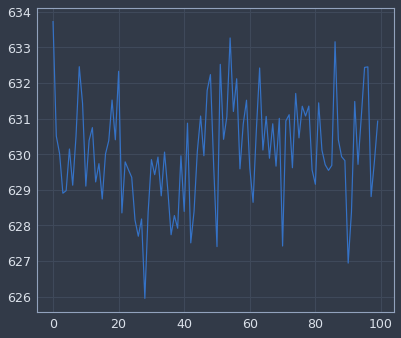

In [9]:
env_kwargs['n_envs'] = 800
episode_reward_sums = a3c_alg.train(n_episodes=100, **rl_alg_kwargs, **env_kwargs)

#episode_reward_sums = a3c_vectorized_env(env, model, optimizer, n_episodes=50, **rl_alg_kwargs)
plt.plot(episode_reward_sums)
plt.show();
#plt.plot(episode_reward_sums);

  0%|          | 0/200 [00:00<?, ?it/s]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #31 with alpha 28.68 and beta 29.21
Opponent 1: Checkpoint #11 with alpha 44.88 and beta 40.54
Opponent 2: Checkpoint #88 with alpha 12.84 and beta 17.62
Opponent 3: Checkpoint #86 with alpha 125.97 and beta 94.11



  0%|          | 1/200 [00:27<1:30:46, 27.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #54 with alpha 36.48 and beta 33.33
Opponent 1: Checkpoint #55 with alpha 9.73 and beta 13.26
Opponent 2: Checkpoint #100 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #53 with alpha 78.79 and beta 66.68



  1%|          | 2/200 [00:55<1:30:42, 27.49s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #17 with alpha 16.45 and beta 18.43
Opponent 1: Checkpoint #8 with alpha 19.11 and beta 21.18
Opponent 2: Checkpoint #95 with alpha 21.42 and beta 21.99
Opponent 3: Checkpoint #91 with alpha 30.19 and beta 29.87



  2%|▏         | 3/200 [01:21<1:28:55, 27.09s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #59 with alpha 18.78 and beta 19.62
Opponent 1: Checkpoint #83 with alpha 28.22 and beta 24.50
Opponent 2: Checkpoint #45 with alpha 71.62 and beta 61.14
Opponent 3: Checkpoint #77 with alpha 65.96 and beta 59.35



  2%|▏         | 4/200 [01:49<1:29:16, 27.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #30 with alpha 91.90 and beta 78.95
Opponent 1: Checkpoint #48 with alpha 15.69 and beta 17.33
Opponent 2: Checkpoint #36 with alpha 46.89 and beta 51.33
Opponent 3: Checkpoint #63 with alpha 9.07 and beta 11.09



  2%|▎         | 5/200 [02:17<1:29:47, 27.63s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #19 with alpha 39.16 and beta 39.83
Opponent 1: Checkpoint #1 with alpha 59.41 and beta 55.24
Opponent 2: Checkpoint #92 with alpha 48.09 and beta 41.85
Opponent 3: Checkpoint #40 with alpha 86.77 and beta 85.67



  3%|▎         | 6/200 [02:45<1:29:34, 27.70s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #13 with alpha 59.74 and beta 54.90
Opponent 1: Checkpoint #60 with alpha 29.77 and beta 26.90
Opponent 2: Checkpoint #9 with alpha 10.00 and beta 13.40
Opponent 3: Checkpoint #54 with alpha 123.12 and beta 93.80



  4%|▎         | 7/200 [03:12<1:28:59, 27.67s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #78 with alpha 103.60 and beta 79.20
Opponent 1: Checkpoint #75 with alpha 64.51 and beta 58.41
Opponent 2: Checkpoint #4 with alpha 11.50 and beta 14.58
Opponent 3: Checkpoint #18 with alpha 30.79 and beta 28.59



  4%|▍         | 8/200 [03:38<1:26:57, 27.17s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #49 with alpha 5.29 and beta 7.05
Opponent 1: Checkpoint #0 with alpha 12.19 and beta 12.90
Opponent 2: Checkpoint #22 with alpha 81.56 and beta 70.35
Opponent 3: Checkpoint #65 with alpha 33.31 and beta 31.79



  4%|▍         | 9/200 [04:04<1:25:06, 26.73s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #32 with alpha 12.42 and beta 13.16
Opponent 1: Checkpoint #67 with alpha 12.59 and beta 14.32
Opponent 2: Checkpoint #100 with alpha 77.17 and beta 63.90
Opponent 3: Checkpoint #68 with alpha 19.46 and beta 19.62



  5%|▌         | 10/200 [04:30<1:23:46, 26.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #47 with alpha 48.14 and beta 39.84
Opponent 1: Checkpoint #47 with alpha 48.14 and beta 39.84
Opponent 2: Checkpoint #44 with alpha 65.66 and beta 53.99
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 28.37 and beta 28.27



  6%|▌         | 11/200 [04:56<1:22:41, 26.25s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #101 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #101 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #87 with alpha 115.05 and beta 90.83
Opponent 3: Checkpoint #59 with alpha 88.93 and beta 76.22



  6%|▌         | 12/200 [05:22<1:21:46, 26.10s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #52 with alpha 85.52 and beta 69.19
Opponent 1: Checkpoint #69 with alpha 12.55 and beta 13.45
Opponent 2: Checkpoint #79 with alpha 60.78 and beta 52.71
Opponent 3: Checkpoint #37 with alpha 25.04 and beta 32.65



  6%|▋         | 13/200 [05:47<1:21:09, 26.04s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #16 with alpha 56.81 and beta 62.53
Opponent 1: Checkpoint #42 with alpha 40.73 and beta 40.86
Opponent 2: Checkpoint #46 with alpha 61.06 and beta 47.81
Opponent 3: Checkpoint #71 with alpha 108.70 and beta 81.71



  7%|▋         | 14/200 [06:13<1:20:28, 25.96s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #55 with alpha 66.87 and beta 53.01
Opponent 1: Checkpoint #6 with alpha 24.37 and beta 22.74
Opponent 2: Checkpoint #27 with alpha 30.84 and beta 36.64
Opponent 3: Checkpoint #61 with alpha 11.46 and beta 14.46



  8%|▊         | 15/200 [06:39<1:19:50, 25.90s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #78 with alpha 147.99 and beta 112.95
Opponent 1: Checkpoint #12 with alpha 35.65 and beta 37.26
Opponent 2: Checkpoint #25 with alpha 27.01 and beta 31.71
Opponent 3: Checkpoint #64 with alpha 28.19 and beta 32.50



  8%|▊         | 16/200 [07:05<1:19:22, 25.88s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #34 with alpha 39.58 and beta 40.53
Opponent 1: Checkpoint #98 with alpha 80.26 and beta 75.28
Opponent 2: Checkpoint #5 with alpha 30.83 and beta 29.13
Opponent 3: Checkpoint #94 with alpha 21.40 and beta 23.62



  8%|▊         | 17/200 [07:31<1:18:48, 25.84s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #83 with alpha 70.74 and beta 57.64
Opponent 1: Checkpoint #85 with alpha 28.30 and beta 26.70
Opponent 2: Checkpoint #21 with alpha 42.68 and beta 36.56
Opponent 3: Checkpoint #83 with alpha 70.74 and beta 57.64



  9%|▉         | 18/200 [07:56<1:18:18, 25.81s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #97 with alpha 28.20 and beta 28.67
Opponent 1: Checkpoint #73 with alpha 32.42 and beta 29.76
Opponent 2: Checkpoint #86 with alpha 91.64 and beta 79.40
Opponent 3: Checkpoint #73 with alpha 32.42 and beta 29.76



 10%|▉         | 19/200 [08:22<1:17:50, 25.80s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #90 with alpha 21.48 and beta 22.76
Opponent 1: Checkpoint #35 with alpha 43.40 and beta 44.07
Opponent 2: Checkpoint #89 with alpha 20.01 and beta 24.58
Opponent 3: Checkpoint #81 with alpha 14.44 and beta 16.84



 10%|█         | 20/200 [08:48<1:17:21, 25.78s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #50 with alpha 62.80 and beta 52.27
Opponent 1: Checkpoint #62 with alpha 21.26 and beta 23.30
Opponent 2: Checkpoint #50 with alpha 62.80 and beta 52.27
Opponent 3: Checkpoint #53 with alpha 69.85 and beta 64.48



 10%|█         | 21/200 [09:14<1:16:54, 25.78s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #102 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #102 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #10 with alpha 10.56 and beta 11.66
Opponent 3: Checkpoint #102 with alpha 1.00 and beta 1.00



 11%|█         | 22/200 [09:39<1:16:27, 25.77s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #38 with alpha 59.30 and beta 50.18
Opponent 1: Checkpoint #60 with alpha 62.44 and beta 55.16
Opponent 2: Checkpoint #58 with alpha 32.46 and beta 31.53
Opponent 3: Checkpoint #66 with alpha 5.44 and beta 7.18



 12%|█▏        | 23/200 [10:05<1:16:01, 25.77s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #52 with alpha 109.42 and beta 98.33
Opponent 1: Checkpoint #29 with alpha 26.15 and beta 29.74
Opponent 2: Checkpoint #70 with alpha 37.21 and beta 33.04
Opponent 3: Checkpoint #26 with alpha 14.59 and beta 16.90



 12%|█▏        | 24/200 [10:31<1:15:39, 25.79s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #23 with alpha 81.09 and beta 72.69
Opponent 1: Checkpoint #43 with alpha 50.07 and beta 44.59
Opponent 2: Checkpoint #51 with alpha 47.69 and beta 45.93
Opponent 3: Checkpoint #20 with alpha 22.59 and beta 20.96



 12%|█▎        | 25/200 [10:57<1:15:13, 25.79s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 52.63 and beta 45.88
Opponent 1: Checkpoint #71 with alpha 117.89 and beta 98.76
Opponent 2: Checkpoint #9 with alpha 41.71 and beta 46.57
Opponent 3: Checkpoint #2 with alpha 54.61 and beta 47.40



 13%|█▎        | 26/200 [11:23<1:14:50, 25.81s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #39 with alpha 17.66 and beta 21.64
Opponent 1: Checkpoint #96 with alpha 19.49 and beta 20.04
Opponent 2: Checkpoint #96 with alpha 19.49 and beta 20.04
Opponent 3: Checkpoint #84 with alpha 18.07 and beta 17.28



 14%|█▎        | 27/200 [11:48<1:14:26, 25.82s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #24 with alpha 15.22 and beta 17.41
Opponent 1: Checkpoint #102 with alpha 252.25 and beta 213.56
Opponent 2: Checkpoint #21 with alpha 88.26 and beta 85.23
Opponent 3: Checkpoint #55 with alpha 93.50 and beta 76.11



 14%|█▍        | 28/200 [12:14<1:13:57, 25.80s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #11 with alpha 34.46 and beta 35.93
Opponent 1: Checkpoint #31 with alpha 30.23 and beta 33.61
Opponent 2: Checkpoint #56 with alpha 20.78 and beta 23.33
Opponent 3: Checkpoint #68 with alpha 47.26 and beta 46.93



 14%|█▍        | 29/200 [12:39<1:12:21, 25.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #54 with alpha 66.80 and beta 64.58
Opponent 1: Checkpoint #67 with alpha 43.38 and beta 41.74
Opponent 2: Checkpoint #6 with alpha 61.76 and beta 57.60
Opponent 3: Checkpoint #77 with alpha 44.29 and beta 44.21



 15%|█▌        | 30/200 [13:02<1:10:11, 24.77s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #82 with alpha 19.49 and beta 22.41
Opponent 1: Checkpoint #8 with alpha 27.95 and beta 31.70
Opponent 2: Checkpoint #3 with alpha 19.30 and beta 22.59
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 48.28 and beta 47.49



 16%|█▌        | 31/200 [13:25<1:08:36, 24.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #103 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #83 with alpha 145.12 and beta 122.82
Opponent 2: Checkpoint #78 with alpha 107.06 and beta 100.44
Opponent 3: Checkpoint #41 with alpha 23.44 and beta 25.13



 16%|█▌        | 32/200 [13:49<1:07:26, 24.09s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #84 with alpha 90.28 and beta 90.47
Opponent 1: Checkpoint #95 with alpha 25.38 and beta 29.12
Opponent 2: Checkpoint #26 with alpha 79.19 and beta 73.35
Opponent 3: Checkpoint #15 with alpha 17.76 and beta 21.70



 16%|█▋        | 33/200 [14:12<1:06:29, 23.89s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #64 with alpha 56.15 and beta 51.59
Opponent 1: Checkpoint #74 with alpha 12.00 and beta 14.26
Opponent 2: Checkpoint #57 with alpha 6.66 and beta 9.71
Opponent 3: Checkpoint #66 with alpha 65.36 and beta 61.56



 17%|█▋        | 34/200 [14:36<1:05:42, 23.75s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #2 with alpha 109.38 and beta 87.59
Opponent 1: Checkpoint #33 with alpha 11.70 and beta 15.57
Opponent 2: Checkpoint #1 with alpha 36.61 and beta 36.86
Opponent 3: Checkpoint #27 with alpha 48.98 and beta 50.68



 18%|█▊        | 35/200 [14:59<1:05:04, 23.66s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #14 with alpha 17.22 and beta 18.89
Opponent 1: Checkpoint #76 with alpha 20.39 and beta 20.87
Opponent 2: Checkpoint #72 with alpha 24.25 and beta 24.07
Opponent 3: Checkpoint #29 with alpha 70.44 and beta 73.52



 18%|█▊        | 36/200 [15:23<1:04:32, 23.62s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #100 with alpha 45.27 and beta 42.74
Opponent 1: Checkpoint #32 with alpha 26.30 and beta 32.81
Opponent 2: Checkpoint #7 with alpha 25.51 and beta 22.82
Opponent 3: Checkpoint #75 with alpha 36.69 and beta 38.64



 18%|█▊        | 37/200 [15:46<1:03:57, 23.54s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #46 with alpha 48.72 and beta 44.54
Opponent 1: Checkpoint #65 with alpha 29.64 and beta 32.63
Opponent 2: Checkpoint #30 with alpha 35.70 and beta 34.48
Opponent 3: Checkpoint #92 with alpha 28.99 and beta 29.21



 19%|█▉        | 38/200 [16:09<1:03:24, 23.48s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #22 with alpha 40.55 and beta 37.24
Opponent 1: Checkpoint #13 with alpha 33.59 and beta 29.39
Opponent 2: Checkpoint #91 with alpha 21.21 and beta 21.49
Opponent 3: Checkpoint #38 with alpha 71.50 and beta 69.34



 20%|█▉        | 39/200 [16:33<1:03:05, 23.51s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #59 with alpha 45.18 and beta 44.16
Opponent 1: Checkpoint #35 with alpha 48.58 and beta 58.25
Opponent 2: Checkpoint #44 with alpha 39.33 and beta 35.27
Opponent 3: Checkpoint #88 with alpha 14.70 and beta 17.90



 20%|██        | 40/200 [16:56<1:02:42, 23.51s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #93 with alpha 13.41 and beta 16.07
Opponent 1: Checkpoint #18 with alpha 23.78 and beta 25.89
Opponent 2: Checkpoint #102 with alpha 182.99 and beta 164.21
Opponent 3: Checkpoint #89 with alpha 45.89 and beta 40.99



 20%|██        | 41/200 [17:20<1:02:14, 23.49s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #5 with alpha 35.56 and beta 39.47
Opponent 1: Checkpoint #4 with alpha 19.12 and beta 22.24
Opponent 2: Checkpoint #63 with alpha 15.64 and beta 18.94
Opponent 3: Checkpoint #71 with alpha 97.29 and beta 90.72



 21%|██        | 42/200 [17:43<1:01:48, 23.47s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #104 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #62 with alpha 39.57 and beta 42.96
Opponent 2: Checkpoint #99 with alpha 21.31 and beta 25.01
Opponent 3: Checkpoint #36 with alpha 21.59 and beta 22.37



 22%|██▏       | 43/200 [18:07<1:01:23, 23.46s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #18 with alpha 117.86 and beta 105.23
Opponent 1: Checkpoint #17 with alpha 13.19 and beta 16.77
Opponent 2: Checkpoint #71 with alpha 196.10 and beta 163.58
Opponent 3: Checkpoint #104 with alpha 113.00 and beta 89.00



 22%|██▏       | 44/200 [18:30<1:00:58, 23.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #47 with alpha 45.50 and beta 43.49
Opponent 1: Checkpoint #80 with alpha 7.71 and beta 11.69
Opponent 2: Checkpoint #13 with alpha 108.65 and beta 92.41
Opponent 3: Checkpoint #28 with alpha 10.00 and beta 11.39



 22%|██▎       | 45/200 [18:54<1:00:35, 23.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #16 with alpha 30.27 and beta 33.62
Opponent 1: Checkpoint #10 with alpha 31.51 and beta 36.45
Opponent 2: Checkpoint #40 with alpha 24.48 and beta 24.74
Opponent 3: Checkpoint #89 with alpha 128.36 and beta 101.77



 23%|██▎       | 46/200 [19:17<1:00:15, 23.48s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #73 with alpha 60.41 and beta 54.52
Opponent 1: Checkpoint #98 with alpha 40.16 and beta 38.41
Opponent 2: Checkpoint #12 with alpha 29.59 and beta 28.20
Opponent 3: Checkpoint #12 with alpha 29.59 and beta 28.20



 24%|██▎       | 47/200 [19:41<59:50, 23.47s/it]  

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #61 with alpha 21.38 and beta 22.13
Opponent 1: Checkpoint #61 with alpha 21.38 and beta 22.13
Opponent 2: Checkpoint #25 with alpha 22.26 and beta 29.90
Opponent 3: Checkpoint #50 with alpha 68.16 and beta 66.05



 24%|██▍       | 48/200 [20:04<59:24, 23.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #103 with alpha 44.01 and beta 44.89
Opponent 1: Checkpoint #87 with alpha 31.76 and beta 30.65
Opponent 2: Checkpoint #90 with alpha 28.52 and beta 29.04
Opponent 3: Checkpoint #49 with alpha 12.04 and beta 16.60



 24%|██▍       | 49/200 [20:27<58:55, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #19 with alpha 13.91 and beta 16.40
Opponent 1: Checkpoint #53 with alpha 38.02 and beta 39.90
Opponent 2: Checkpoint #23 with alpha 51.25 and beta 49.80
Opponent 3: Checkpoint #42 with alpha 21.46 and beta 24.63



 25%|██▌       | 50/200 [20:51<58:29, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #21 with alpha 58.03 and beta 60.01
Opponent 1: Checkpoint #58 with alpha 33.01 and beta 32.28
Opponent 2: Checkpoint #39 with alpha 34.05 and beta 38.90
Opponent 3: Checkpoint #81 with alpha 22.80 and beta 26.51



 26%|██▌       | 51/200 [21:14<58:03, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #105 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #10 with alpha 110.60 and beta 94.11
Opponent 2: Checkpoint #105 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #105 with alpha 1.00 and beta 1.00



 26%|██▌       | 52/200 [21:37<57:41, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #94 with alpha 19.49 and beta 20.83
Opponent 1: Checkpoint #41 with alpha 44.37 and beta 43.87
Opponent 2: Checkpoint #100 with alpha 66.49 and beta 64.91
Opponent 3: Checkpoint #38 with alpha 92.11 and beta 79.25



 26%|██▋       | 53/200 [22:01<57:21, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #34 with alpha 20.05 and beta 23.51
Opponent 1: Checkpoint #86 with alpha 32.27 and beta 31.11
Opponent 2: Checkpoint #43 with alpha 34.74 and beta 34.21
Opponent 3: Checkpoint #32 with alpha 56.33 and beta 56.41



 27%|██▋       | 54/200 [22:24<56:57, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #0 with alpha 36.27 and beta 33.56
Opponent 1: Checkpoint #30 with alpha 59.38 and beta 57.99
Opponent 2: Checkpoint #0 with alpha 36.27 and beta 33.56
Opponent 3: Checkpoint #24 with alpha 30.56 and beta 30.32



 28%|██▊       | 55/200 [22:48<56:31, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #101 with alpha 21.54 and beta 22.75
Opponent 1: Checkpoint #31 with alpha 33.79 and beta 34.90
Opponent 2: Checkpoint #63 with alpha 63.58 and beta 55.95
Opponent 3: SavedRLAgent: a3c_agent_v3 with alpha 39.96 and beta 45.00



 28%|██▊       | 56/200 [23:11<56:05, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #45 with alpha 11.04 and beta 11.60
Opponent 1: Checkpoint #52 with alpha 39.99 and beta 36.98
Opponent 2: Checkpoint #90 with alpha 89.10 and beta 88.75
Opponent 3: Checkpoint #22 with alpha 58.96 and beta 55.56



 28%|██▊       | 57/200 [23:34<55:40, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #60 with alpha 26.45 and beta 28.04
Opponent 1: Checkpoint #99 with alpha 55.96 and beta 63.04
Opponent 2: Checkpoint #89 with alpha 129.09 and beta 109.03
Opponent 3: Checkpoint #97 with alpha 15.92 and beta 20.25



 29%|██▉       | 58/200 [23:58<55:20, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #37 with alpha 10.72 and beta 14.62
Opponent 1: Checkpoint #67 with alpha 31.92 and beta 34.88
Opponent 2: Checkpoint #35 with alpha 62.82 and beta 56.94
Opponent 3: Checkpoint #48 with alpha 6.16 and beta 9.10



 30%|██▉       | 59/200 [24:21<54:56, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #31 with alpha 123.55 and beta 103.87
Opponent 1: Checkpoint #36 with alpha 54.58 and beta 51.83
Opponent 2: Checkpoint #10 with alpha 154.03 and beta 121.44
Opponent 3: Checkpoint #68 with alpha 31.96 and beta 30.17



 30%|███       | 60/200 [24:45<54:34, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #1 with alpha 37.39 and beta 37.45
Opponent 1: Checkpoint #66 with alpha 43.24 and beta 41.24
Opponent 2: Checkpoint #84 with alpha 44.13 and beta 48.93
Opponent 3: Checkpoint #15 with alpha 29.51 and beta 29.94



 30%|███       | 61/200 [25:08<54:12, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #16 with alpha 60.35 and beta 60.43
Opponent 1: Checkpoint #70 with alpha 18.71 and beta 21.27
Opponent 2: Checkpoint #85 with alpha 13.32 and beta 14.47
Opponent 3: Checkpoint #3 with alpha 24.54 and beta 26.93



 31%|███       | 62/200 [25:31<53:49, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #106 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #106 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #106 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #104 with alpha 81.77 and beta 73.90



 32%|███▏      | 63/200 [25:55<53:25, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #79 with alpha 11.60 and beta 12.09
Opponent 1: Checkpoint #83 with alpha 48.60 and beta 44.08
Opponent 2: Checkpoint #72 with alpha 30.80 and beta 30.76
Opponent 3: Checkpoint #79 with alpha 11.60 and beta 12.09



 32%|███▏      | 64/200 [26:18<52:59, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #101 with alpha 90.53 and beta 70.07
Opponent 1: Checkpoint #18 with alpha 75.99 and beta 71.69
Opponent 2: Checkpoint #8 with alpha 22.09 and beta 25.14
Opponent 3: Checkpoint #10 with alpha 215.30 and beta 160.76



 32%|███▎      | 65/200 [26:42<52:38, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #17 with alpha 40.88 and beta 36.93
Opponent 1: Checkpoint #71 with alpha 98.01 and beta 86.47
Opponent 2: Checkpoint #91 with alpha 33.37 and beta 30.02
Opponent 3: Checkpoint #20 with alpha 13.68 and beta 17.34



 33%|███▎      | 66/200 [27:05<52:18, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #69 with alpha 5.97 and beta 8.86
Opponent 1: Checkpoint #33 with alpha 21.03 and beta 25.04
Opponent 2: Checkpoint #96 with alpha 30.44 and beta 28.75
Opponent 3: Checkpoint #78 with alpha 34.74 and beta 34.69



 34%|███▎      | 67/200 [27:29<51:58, 23.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #56 with alpha 16.69 and beta 17.75
Opponent 1: Checkpoint #2 with alpha 39.02 and beta 35.97
Opponent 2: Checkpoint #77 with alpha 19.42 and beta 23.16
Opponent 3: Checkpoint #17 with alpha 137.59 and beta 122.63



 34%|███▍      | 68/200 [27:52<51:35, 23.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #74 with alpha 18.69 and beta 20.64
Opponent 1: Checkpoint #31 with alpha 152.17 and beta 123.85
Opponent 2: Checkpoint #41 with alpha 70.03 and beta 61.47
Opponent 3: Checkpoint #19 with alpha 46.36 and beta 44.52



 34%|███▍      | 69/200 [28:15<51:13, 23.46s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #52 with alpha 80.78 and beta 66.81
Opponent 1: Checkpoint #65 with alpha 23.69 and beta 29.16
Opponent 2: Checkpoint #73 with alpha 51.24 and beta 48.79
Opponent 3: Checkpoint #43 with alpha 64.17 and beta 58.84



 35%|███▌      | 70/200 [28:39<50:53, 23.49s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #51 with alpha 13.65 and beta 15.08
Opponent 1: Checkpoint #27 with alpha 22.43 and beta 26.51
Opponent 2: Checkpoint #10 with alpha 243.38 and beta 187.81
Opponent 3: Checkpoint #7 with alpha 20.38 and beta 24.88



 36%|███▌      | 71/200 [29:02<50:25, 23.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #82 with alpha 13.95 and beta 16.87
Opponent 1: Checkpoint #107 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #9 with alpha 12.79 and beta 15.44
Opponent 3: Checkpoint #92 with alpha 22.18 and beta 24.80



 36%|███▌      | 72/200 [29:26<50:00, 23.44s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #63 with alpha 68.84 and beta 69.17
Opponent 1: Checkpoint #47 with alpha 35.60 and beta 35.63
Opponent 2: Checkpoint #81 with alpha 43.31 and beta 40.76
Opponent 3: Checkpoint #75 with alpha 21.98 and beta 23.12



 36%|███▋      | 73/200 [29:49<49:32, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #88 with alpha 19.41 and beta 23.10
Opponent 1: Checkpoint #80 with alpha 22.79 and beta 29.16
Opponent 2: Checkpoint #28 with alpha 26.16 and beta 26.24
Opponent 3: Checkpoint #37 with alpha 57.15 and beta 52.13



 37%|███▋      | 74/200 [30:12<49:07, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #10 with alpha 294.26 and beta 228.42
Opponent 1: Checkpoint #36 with alpha 74.79 and beta 72.05
Opponent 2: Checkpoint #55 with alpha 16.80 and beta 17.32
Opponent 3: Checkpoint #65 with alpha 104.26 and beta 99.53



 38%|███▊      | 75/200 [30:36<48:46, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #93 with alpha 17.00 and beta 22.86
Opponent 1: Checkpoint #64 with alpha 18.96 and beta 17.95
Opponent 2: Checkpoint #76 with alpha 14.52 and beta 17.83
Opponent 3: Checkpoint #102 with alpha 47.79 and beta 44.84



 38%|███▊      | 76/200 [30:59<48:22, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #10 with alpha 380.52 and beta 281.20
Opponent 1: Checkpoint #59 with alpha 21.60 and beta 23.34
Opponent 2: Checkpoint #14 with alpha 13.09 and beta 17.02
Opponent 3: Checkpoint #89 with alpha 90.42 and beta 78.88



 38%|███▊      | 77/200 [31:23<47:57, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #13 with alpha 38.69 and beta 37.05
Opponent 1: Checkpoint #13 with alpha 38.69 and beta 37.05
Opponent 2: Checkpoint #54 with alpha 14.04 and beta 15.11
Opponent 3: Checkpoint #61 with alpha 49.44 and beta 50.28



 39%|███▉      | 78/200 [31:46<47:35, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #72 with alpha 66.21 and beta 59.85
Opponent 1: Checkpoint #48 with alpha 39.57 and beta 41.38
Opponent 2: Checkpoint #4 with alpha 17.22 and beta 20.53
Opponent 3: Checkpoint #91 with alpha 73.33 and beta 67.28



 40%|███▉      | 79/200 [32:09<47:10, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #26 with alpha 15.37 and beta 17.21
Opponent 1: Checkpoint #54 with alpha 122.40 and beta 93.91
Opponent 2: Checkpoint #24 with alpha 37.38 and beta 37.90
Opponent 3: Checkpoint #51 with alpha 73.29 and beta 77.50



 40%|████      | 80/200 [32:33<46:43, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #35 with alpha 56.76 and beta 50.09
Opponent 1: Checkpoint #49 with alpha 19.77 and beta 26.56
Opponent 2: Checkpoint #71 with alpha 92.23 and beta 90.78
Opponent 3: Checkpoint #44 with alpha 15.85 and beta 18.96



 40%|████      | 81/200 [32:56<46:20, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #108 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #108 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #21 with alpha 32.65 and beta 34.34
Opponent 3: Checkpoint #36 with alpha 134.56 and beta 115.00



 41%|████      | 82/200 [33:19<45:55, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #33 with alpha 58.59 and beta 54.34
Opponent 1: Checkpoint #55 with alpha 83.42 and beta 78.88
Opponent 2: Checkpoint #95 with alpha 9.20 and beta 11.19
Opponent 3: Checkpoint #5 with alpha 16.87 and beta 17.99



 42%|████▏     | 83/200 [33:43<45:31, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #63 with alpha 105.61 and beta 92.63
Opponent 1: Checkpoint #12 with alpha 35.75 and beta 36.02
Opponent 2: Checkpoint #103 with alpha 23.57 and beta 26.16
Opponent 3: Checkpoint #45 with alpha 28.59 and beta 29.78



 42%|████▏     | 84/200 [34:06<45:08, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #107 with alpha 57.01 and beta 52.14
Opponent 1: Checkpoint #50 with alpha 24.50 and beta 27.18
Opponent 2: Checkpoint #47 with alpha 80.67 and beta 71.58
Opponent 3: Checkpoint #35 with alpha 145.69 and beta 112.82



 42%|████▎     | 85/200 [34:29<44:43, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #6 with alpha 8.26 and beta 10.40
Opponent 1: Checkpoint #30 with alpha 34.43 and beta 32.43
Opponent 2: Checkpoint #23 with alpha 23.20 and beta 25.96
Opponent 3: Checkpoint #47 with alpha 186.14 and beta 158.50



 43%|████▎     | 86/200 [34:53<44:20, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #101 with alpha 62.15 and beta 57.92
Opponent 1: Checkpoint #7 with alpha 55.30 and beta 57.28
Opponent 2: Checkpoint #54 with alpha 168.54 and beta 129.53
Opponent 3: Checkpoint #2 with alpha 55.04 and beta 52.70



 44%|████▎     | 87/200 [35:16<43:57, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #15 with alpha 35.72 and beta 31.87
Opponent 1: Checkpoint #40 with alpha 12.79 and beta 17.34
Opponent 2: Checkpoint #103 with alpha 116.08 and beta 95.90
Opponent 3: Checkpoint #42 with alpha 18.12 and beta 18.42



 44%|████▍     | 88/200 [35:40<43:34, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #81 with alpha 65.39 and beta 64.27
Opponent 1: Checkpoint #48 with alpha 85.77 and beta 88.74
Opponent 2: Checkpoint #62 with alpha 13.28 and beta 14.40
Opponent 3: Checkpoint #41 with alpha 63.03 and beta 59.58



 44%|████▍     | 89/200 [36:03<43:14, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #57 with alpha 5.20 and beta 7.63
Opponent 1: Checkpoint #29 with alpha 10.42 and beta 11.80
Opponent 2: Checkpoint #80 with alpha 60.53 and beta 54.99
Opponent 3: Checkpoint #102 with alpha 80.03 and beta 67.81



 45%|████▌     | 90/200 [36:26<42:55, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #87 with alpha 15.04 and beta 16.62
Opponent 1: Checkpoint #46 with alpha 10.26 and beta 9.78
Opponent 2: Checkpoint #87 with alpha 15.04 and beta 16.62
Opponent 3: Checkpoint #58 with alpha 17.43 and beta 18.01



 46%|████▌     | 91/200 [36:50<42:33, 23.43s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #39 with alpha 15.92 and beta 18.69
Opponent 1: Checkpoint #32 with alpha 22.19 and beta 23.85
Opponent 2: Checkpoint #109 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #56 with alpha 37.76 and beta 33.77



 46%|████▌     | 92/200 [37:13<42:09, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #93 with alpha 52.66 and beta 52.03
Opponent 1: Checkpoint #79 with alpha 45.07 and beta 55.41
Opponent 2: Checkpoint #64 with alpha 56.34 and beta 47.12
Opponent 3: Checkpoint #84 with alpha 28.43 and beta 30.38



 46%|████▋     | 93/200 [37:37<41:47, 23.44s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #86 with alpha 16.05 and beta 19.15
Opponent 1: Checkpoint #96 with alpha 34.24 and beta 33.29
Opponent 2: Checkpoint #53 with alpha 14.34 and beta 15.86
Opponent 3: Checkpoint #74 with alpha 32.19 and beta 37.11



 47%|████▋     | 94/200 [38:00<41:20, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #77 with alpha 31.08 and beta 32.28
Opponent 1: Checkpoint #75 with alpha 44.40 and beta 38.30
Opponent 2: Checkpoint #11 with alpha 3.86 and beta 5.65
Opponent 3: Checkpoint #48 with alpha 147.00 and beta 136.04



 48%|████▊     | 95/200 [38:24<40:57, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #18 with alpha 36.31 and beta 36.72
Opponent 1: Checkpoint #45 with alpha 83.70 and beta 61.60
Opponent 2: Checkpoint #38 with alpha 21.57 and beta 20.50
Opponent 3: Checkpoint #1 with alpha 22.03 and beta 25.36



 48%|████▊     | 96/200 [38:47<40:34, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 18.12 and beta 17.96
Opponent 1: Checkpoint #76 with alpha 44.02 and beta 38.70
Opponent 2: Checkpoint #76 with alpha 44.02 and beta 38.70
Opponent 3: Checkpoint #7 with alpha 104.64 and beta 88.81



 48%|████▊     | 97/200 [39:10<40:09, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #54 with alpha 156.04 and beta 133.25
Opponent 1: Checkpoint #0 with alpha 28.29 and beta 25.79
Opponent 2: Checkpoint #20 with alpha 22.63 and beta 24.16
Opponent 3: Checkpoint #45 with alpha 181.47 and beta 139.67



 49%|████▉     | 98/200 [39:34<39:44, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #71 with alpha 85.34 and beta 70.97
Opponent 1: Checkpoint #43 with alpha 36.26 and beta 39.10
Opponent 2: Checkpoint #83 with alpha 24.16 and beta 26.20
Opponent 3: Checkpoint #78 with alpha 26.92 and beta 27.31



 50%|████▉     | 99/200 [39:57<39:17, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #31 with alpha 52.60 and beta 46.61
Opponent 1: Checkpoint #100 with alpha 14.85 and beta 15.84
Opponent 2: Checkpoint #31 with alpha 52.60 and beta 46.61
Opponent 3: Checkpoint #69 with alpha 19.40 and beta 22.07



 50%|█████     | 100/200 [40:20<38:54, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #72 with alpha 59.73 and beta 49.16
Opponent 1: Checkpoint #94 with alpha 8.89 and beta 12.50
Opponent 2: Checkpoint #60 with alpha 13.30 and beta 15.91
Opponent 3: Checkpoint #12 with alpha 61.16 and beta 56.87



 50%|█████     | 101/200 [40:44<38:33, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #110 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #110 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #88 with alpha 30.65 and beta 29.53
Opponent 3: Checkpoint #110 with alpha 1.00 and beta 1.00



 51%|█████     | 102/200 [41:07<38:07, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #71 with alpha 165.97 and beta 132.83
Opponent 1: Checkpoint #80 with alpha 89.70 and beta 77.67
Opponent 2: Checkpoint #24 with alpha 47.56 and beta 40.28
Opponent 3: Checkpoint #6 with alpha 51.65 and beta 44.18



 52%|█████▏    | 103/200 [41:30<37:44, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #35 with alpha 99.27 and beta 77.73
Opponent 1: Checkpoint #70 with alpha 14.26 and beta 14.80
Opponent 2: Checkpoint #98 with alpha 6.82 and beta 8.71
Opponent 3: Checkpoint #70 with alpha 14.26 and beta 14.80



 52%|█████▏    | 104/200 [41:54<37:22, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #22 with alpha 12.84 and beta 14.88
Opponent 1: Checkpoint #17 with alpha 37.35 and beta 33.21
Opponent 2: Checkpoint #21 with alpha 42.23 and beta 43.07
Opponent 3: Checkpoint #37 with alpha 32.15 and beta 33.06



 52%|█████▎    | 105/200 [42:17<36:58, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #36 with alpha 71.41 and beta 62.93
Opponent 1: Checkpoint #4 with alpha 27.50 and beta 34.65
Opponent 2: Checkpoint #64 with alpha 85.66 and beta 75.52
Opponent 3: Checkpoint #73 with alpha 24.86 and beta 24.14



 53%|█████▎    | 106/200 [42:41<36:41, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #92 with alpha 20.90 and beta 21.86
Opponent 1: Checkpoint #105 with alpha 17.83 and beta 19.90
Opponent 2: Checkpoint #97 with alpha 8.75 and beta 11.23
Opponent 3: Checkpoint #104 with alpha 18.31 and beta 20.02



 54%|█████▎    | 107/200 [43:04<36:17, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #29 with alpha 47.41 and beta 45.04
Opponent 1: Checkpoint #3 with alpha 11.02 and beta 13.73
Opponent 2: Checkpoint #46 with alpha 53.81 and beta 42.60
Opponent 3: Checkpoint #25 with alpha 5.10 and beta 7.00



 54%|█████▍    | 108/200 [43:27<35:53, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #102 with alpha 69.52 and beta 65.71
Opponent 1: Checkpoint #51 with alpha 41.77 and beta 39.87
Opponent 2: Checkpoint #13 with alpha 51.89 and beta 49.41
Opponent 3: Checkpoint #89 with alpha 36.89 and beta 36.69



 55%|█████▍    | 109/200 [43:51<35:32, 23.44s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #38 with alpha 67.50 and beta 55.69
Opponent 1: Checkpoint #22 with alpha 105.23 and beta 79.12
Opponent 2: Checkpoint #63 with alpha 54.32 and beta 53.40
Opponent 3: Checkpoint #85 with alpha 9.03 and beta 11.29



 55%|█████▌    | 110/200 [44:14<35:07, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #106 with alpha 26.56 and beta 27.46
Opponent 1: Checkpoint #50 with alpha 35.58 and beta 33.51
Opponent 2: Checkpoint #99 with alpha 9.77 and beta 11.97
Opponent 3: Checkpoint #100 with alpha 74.31 and beta 62.90



 56%|█████▌    | 111/200 [44:38<34:41, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #96 with alpha 58.97 and beta 51.48
Opponent 1: Checkpoint #91 with alpha 35.29 and beta 29.33
Opponent 2: Checkpoint #111 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #111 with alpha 1.00 and beta 1.00



 56%|█████▌    | 112/200 [45:01<34:19, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #52 with alpha 20.50 and beta 18.96
Opponent 1: Checkpoint #9 with alpha 13.58 and beta 15.57
Opponent 2: Checkpoint #66 with alpha 9.51 and beta 10.98
Opponent 3: Checkpoint #46 with alpha 137.34 and beta 100.16



 56%|█████▋    | 113/200 [45:24<33:53, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #32 with alpha 41.92 and beta 41.09
Opponent 1: Checkpoint #24 with alpha 94.41 and beta 75.30
Opponent 2: Checkpoint #26 with alpha 21.00 and beta 21.50
Opponent 3: Checkpoint #61 with alpha 23.74 and beta 25.21



 57%|█████▋    | 114/200 [45:48<33:29, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #63 with alpha 144.25 and beta 102.00
Opponent 1: Checkpoint #34 with alpha 5.05 and beta 6.07
Opponent 2: Checkpoint #90 with alpha 9.33 and beta 10.49
Opponent 3: Checkpoint #67 with alpha 6.51 and beta 9.18



 57%|█████▊    | 115/200 [46:11<33:05, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #30 with alpha 30.10 and beta 29.44
Opponent 1: Checkpoint #27 with alpha 10.66 and beta 15.15
Opponent 2: Checkpoint #33 with alpha 29.09 and beta 30.44
Opponent 3: Checkpoint #30 with alpha 30.10 and beta 29.44



 58%|█████▊    | 116/200 [46:34<32:43, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #19 with alpha 12.25 and beta 13.44
Opponent 1: Checkpoint #8 with alpha 8.66 and beta 9.24
Opponent 2: Checkpoint #68 with alpha 6.72 and beta 7.93
Opponent 3: Checkpoint #95 with alpha 17.62 and beta 22.75



 58%|█████▊    | 117/200 [46:58<32:19, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #103 with alpha 47.73 and beta 42.95
Opponent 1: Checkpoint #44 with alpha 18.63 and beta 18.15
Opponent 2: Checkpoint #28 with alpha 13.48 and beta 14.04
Opponent 3: Checkpoint #83 with alpha 51.22 and beta 47.23



 59%|█████▉    | 118/200 [47:21<31:55, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 38.21 and beta 41.57
Opponent 1: Checkpoint #16 with alpha 8.67 and beta 9.13
Opponent 2: Checkpoint #23 with alpha 23.93 and beta 23.86
Opponent 3: Checkpoint #13 with alpha 97.56 and beta 89.14



 60%|█████▉    | 119/200 [47:45<31:33, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #42 with alpha 23.90 and beta 23.96
Opponent 1: Checkpoint #18 with alpha 45.49 and beta 37.31
Opponent 2: Checkpoint #53 with alpha 29.71 and beta 33.72
Opponent 3: Checkpoint #10 with alpha 51.09 and beta 45.02



 60%|██████    | 120/200 [48:08<31:10, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #87 with alpha 48.19 and beta 48.98
Opponent 1: Checkpoint #24 with alpha 147.53 and beta 118.01
Opponent 2: Checkpoint #73 with alpha 60.53 and beta 59.71
Opponent 3: Checkpoint #14 with alpha 11.67 and beta 13.52



 60%|██████    | 121/200 [48:31<30:46, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #112 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #48 with alpha 63.94 and beta 59.62
Opponent 2: Checkpoint #112 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #88 with alpha 47.97 and beta 49.07



 61%|██████    | 122/200 [48:55<30:20, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #84 with alpha 28.24 and beta 29.57
Opponent 1: Checkpoint #45 with alpha 82.02 and beta 65.46
Opponent 2: Checkpoint #81 with alpha 26.15 and beta 33.32
Opponent 3: Checkpoint #49 with alpha 14.87 and beta 14.92



 62%|██████▏   | 123/200 [49:18<29:59, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #59 with alpha 11.57 and beta 11.35
Opponent 1: Checkpoint #69 with alpha 33.64 and beta 39.95
Opponent 2: Checkpoint #59 with alpha 11.57 and beta 11.35
Opponent 3: Checkpoint #51 with alpha 69.34 and beta 66.02



 62%|██████▏   | 124/200 [49:41<29:38, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #65 with alpha 16.16 and beta 15.72
Opponent 1: Checkpoint #93 with alpha 28.86 and beta 32.20
Opponent 2: Checkpoint #40 with alpha 16.43 and beta 19.64
Opponent 3: Checkpoint #2 with alpha 20.80 and beta 24.52



 62%|██████▎   | 125/200 [50:05<29:15, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #64 with alpha 69.01 and beta 64.24
Opponent 1: Checkpoint #101 with alpha 22.15 and beta 22.57
Opponent 2: Checkpoint #38 with alpha 81.13 and beta 65.74
Opponent 3: Checkpoint #55 with alpha 20.04 and beta 21.04



 63%|██████▎   | 126/200 [50:28<28:52, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #98 with alpha 36.72 and beta 32.77
Opponent 1: Checkpoint #86 with alpha 21.36 and beta 23.86
Opponent 2: Checkpoint #77 with alpha 24.17 and beta 28.89
Opponent 3: Checkpoint #74 with alpha 24.33 and beta 27.17



 64%|██████▎   | 127/200 [50:52<28:28, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #111 with alpha 98.45 and beta 87.79
Opponent 1: Checkpoint #72 with alpha 41.04 and beta 38.92
Opponent 2: Checkpoint #52 with alpha 65.34 and beta 50.48
Opponent 3: Checkpoint #40 with alpha 116.97 and beta 94.45



 64%|██████▍   | 128/200 [51:15<28:04, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #42 with alpha 87.04 and beta 75.80
Opponent 1: Checkpoint #61 with alpha 64.89 and beta 55.32
Opponent 2: Checkpoint #82 with alpha 5.87 and beta 7.10
Opponent 3: Checkpoint #108 with alpha 17.10 and beta 20.88



 64%|██████▍   | 129/200 [51:38<27:39, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #94 with alpha 25.91 and beta 26.49
Opponent 1: Checkpoint #28 with alpha 66.44 and beta 62.19
Opponent 2: Checkpoint #0 with alpha 26.48 and beta 24.78
Opponent 3: Checkpoint #15 with alpha 15.98 and beta 16.27



 65%|██████▌   | 130/200 [52:02<27:15, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #105 with alpha 36.25 and beta 36.24
Opponent 1: Checkpoint #1 with alpha 21.67 and beta 21.17
Opponent 2: Checkpoint #83 with alpha 80.06 and beta 78.55
Opponent 3: Checkpoint #109 with alpha 12.89 and beta 15.88



 66%|██████▌   | 131/200 [52:25<26:51, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #19 with alpha 57.13 and beta 52.31
Opponent 1: Checkpoint #107 with alpha 14.28 and beta 14.41
Opponent 2: Checkpoint #34 with alpha 47.00 and beta 45.67
Opponent 3: Checkpoint #96 with alpha 58.31 and beta 56.76



 66%|██████▌   | 132/200 [52:48<26:26, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #113 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #113 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #71 with alpha 59.35 and beta 49.97
Opponent 3: Checkpoint #113 with alpha 1.00 and beta 1.00



 66%|██████▋   | 133/200 [53:12<26:07, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #22 with alpha 63.46 and beta 51.84
Opponent 1: Checkpoint #35 with alpha 43.45 and beta 39.73
Opponent 2: Checkpoint #17 with alpha 31.15 and beta 32.36
Opponent 3: Checkpoint #46 with alpha 84.77 and beta 67.81



 67%|██████▋   | 134/200 [53:35<25:44, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #60 with alpha 19.44 and beta 22.47
Opponent 1: Checkpoint #106 with alpha 41.26 and beta 35.99
Opponent 2: Checkpoint #71 with alpha 152.84 and beta 135.83
Opponent 3: Checkpoint #12 with alpha 29.28 and beta 28.16



 68%|██████▊   | 135/200 [53:59<25:18, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #53 with alpha 63.58 and beta 57.00
Opponent 1: Checkpoint #54 with alpha 36.61 and beta 34.56
Opponent 2: Checkpoint #78 with alpha 19.34 and beta 20.35
Opponent 3: Checkpoint #80 with alpha 35.30 and beta 34.25



 68%|██████▊   | 136/200 [54:22<24:53, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #82 with alpha 80.71 and beta 67.56
Opponent 1: Checkpoint #100 with alpha 48.43 and beta 43.20
Opponent 2: Checkpoint #73 with alpha 76.68 and beta 68.90
Opponent 3: Checkpoint #5 with alpha 6.93 and beta 8.45



 68%|██████▊   | 137/200 [54:45<24:29, 23.32s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #47 with alpha 19.83 and beta 18.72
Opponent 1: Checkpoint #30 with alpha 79.55 and beta 75.93
Opponent 2: Checkpoint #26 with alpha 40.86 and beta 33.02
Opponent 3: Checkpoint #75 with alpha 16.43 and beta 15.88



 69%|██████▉   | 138/200 [55:09<24:06, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #62 with alpha 8.80 and beta 9.53
Opponent 1: Checkpoint #85 with alpha 25.11 and beta 27.05
Opponent 2: Checkpoint #56 with alpha 11.65 and beta 13.66
Opponent 3: Checkpoint #4 with alpha 25.50 and beta 24.68



 70%|██████▉   | 139/200 [55:32<23:44, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #83 with alpha 124.76 and beta 107.89
Opponent 1: Checkpoint #41 with alpha 11.57 and beta 12.78
Opponent 2: Checkpoint #14 with alpha 43.73 and beta 45.22
Opponent 3: Checkpoint #70 with alpha 36.30 and beta 34.72



 70%|███████   | 140/200 [55:55<23:24, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #33 with alpha 40.19 and beta 34.72
Opponent 1: Checkpoint #39 with alpha 7.94 and beta 11.92
Opponent 2: Checkpoint #31 with alpha 32.19 and beta 31.33
Opponent 3: Checkpoint #41 with alpha 131.99 and beta 91.14



 70%|███████   | 141/200 [56:19<22:59, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #114 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #114 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #58 with alpha 7.74 and beta 10.24
Opponent 3: Checkpoint #2 with alpha 56.23 and beta 50.74



 71%|███████   | 142/200 [56:42<22:35, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #23 with alpha 35.73 and beta 39.70
Opponent 1: Checkpoint #65 with alpha 49.90 and beta 46.38
Opponent 2: Checkpoint #29 with alpha 25.71 and beta 24.61
Opponent 3: Checkpoint #8 with alpha 31.96 and beta 28.23



 72%|███████▏  | 143/200 [57:06<22:15, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #90 with alpha 26.72 and beta 25.32
Opponent 1: Checkpoint #37 with alpha 18.66 and beta 18.64
Opponent 2: Checkpoint #38 with alpha 79.06 and beta 62.91
Opponent 3: Checkpoint #11 with alpha 7.77 and beta 10.05



 72%|███████▏  | 144/200 [57:29<21:58, 23.54s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #92 with alpha 17.52 and beta 18.55
Opponent 1: Checkpoint #21 with alpha 18.28 and beta 19.74
Opponent 2: Checkpoint #45 with alpha 63.49 and beta 52.34
Opponent 3: Checkpoint #15 with alpha 59.10 and beta 53.38



 72%|███████▎  | 145/200 [57:53<21:32, 23.49s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #20 with alpha 10.81 and beta 11.12
Opponent 1: Checkpoint #87 with alpha 43.73 and beta 41.62
Opponent 2: Checkpoint #41 with alpha 191.32 and beta 144.24
Opponent 3: Checkpoint #97 with alpha 14.64 and beta 16.54



 73%|███████▎  | 146/200 [58:16<21:07, 23.47s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #57 with alpha 4.95 and beta 7.06
Opponent 1: Checkpoint #67 with alpha 22.37 and beta 21.45
Opponent 2: Checkpoint #91 with alpha 21.77 and beta 23.93
Opponent 3: Checkpoint #104 with alpha 16.35 and beta 15.63



 74%|███████▎  | 147/200 [58:40<20:44, 23.47s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #89 with alpha 19.30 and beta 19.13
Opponent 1: Checkpoint #50 with alpha 20.24 and beta 21.67
Opponent 2: Checkpoint #7 with alpha 13.84 and beta 15.69
Opponent 3: Checkpoint #101 with alpha 44.12 and beta 38.46



 74%|███████▍  | 148/200 [59:03<20:18, 23.44s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #101 with alpha 151.91 and beta 126.54
Opponent 1: Checkpoint #76 with alpha 17.20 and beta 17.78
Opponent 2: Checkpoint #52 with alpha 56.84 and beta 54.29
Opponent 3: Checkpoint #25 with alpha 13.22 and beta 13.96



 74%|███████▍  | 149/200 [59:26<19:52, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #102 with alpha 21.47 and beta 20.74
Opponent 1: Checkpoint #42 with alpha 69.62 and beta 57.54
Opponent 2: Checkpoint #66 with alpha 14.36 and beta 20.26
Opponent 3: Checkpoint #43 with alpha 10.23 and beta 10.67



 75%|███████▌  | 150/200 [59:50<19:29, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #72 with alpha 43.19 and beta 46.10
Opponent 1: Checkpoint #88 with alpha 35.22 and beta 34.28
Opponent 2: Checkpoint #55 with alpha 34.32 and beta 35.47
Opponent 3: Checkpoint #111 with alpha 63.10 and beta 58.85



 76%|███████▌  | 151/200 [1:00:13<19:04, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #36 with alpha 16.09 and beta 16.49
Opponent 1: Checkpoint #115 with alpha 1.00 and beta 1.00
Opponent 2: Checkpoint #99 with alpha 12.57 and beta 15.79
Opponent 3: Checkpoint #22 with alpha 68.90 and beta 60.52



 76%|███████▌  | 152/200 [1:00:36<18:40, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #106 with alpha 63.43 and beta 50.88
Opponent 1: Checkpoint #79 with alpha 6.61 and beta 7.72
Opponent 2: Checkpoint #55 with alpha 136.90 and beta 116.09
Opponent 3: Checkpoint #32 with alpha 19.48 and beta 20.23



 76%|███████▋  | 153/200 [1:01:00<18:17, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #43 with alpha 109.50 and beta 78.99
Opponent 1: Checkpoint #95 with alpha 17.87 and beta 19.74
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 22.69 and beta 25.52
Opponent 3: Checkpoint #84 with alpha 27.87 and beta 26.85



 77%|███████▋  | 154/200 [1:01:23<17:53, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #13 with alpha 31.09 and beta 31.59
Opponent 1: Checkpoint #6 with alpha 10.42 and beta 10.85
Opponent 2: Checkpoint #105 with alpha 38.86 and beta 43.78
Opponent 3: Checkpoint #90 with alpha 74.77 and beta 74.58



 78%|███████▊  | 155/200 [1:01:46<17:31, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #3 with alpha 9.51 and beta 10.55
Opponent 1: Checkpoint #112 with alpha 35.98 and beta 38.00
Opponent 2: Checkpoint #47 with alpha 53.45 and beta 45.48
Opponent 3: Checkpoint #30 with alpha 72.58 and beta 72.81



 78%|███████▊  | 156/200 [1:02:10<17:07, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #93 with alpha 27.00 and beta 25.61
Opponent 1: Checkpoint #41 with alpha 169.30 and beta 141.32
Opponent 2: Checkpoint #78 with alpha 44.94 and beta 40.27
Opponent 3: Checkpoint #87 with alpha 88.64 and beta 79.65



 78%|███████▊  | 157/200 [1:02:33<16:43, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #45 with alpha 89.87 and beta 77.66
Opponent 1: Checkpoint #63 with alpha 25.98 and beta 24.34
Opponent 2: Checkpoint #9 with alpha 11.71 and beta 12.12
Opponent 3: Checkpoint #115 with alpha 84.73 and beta 71.57



 79%|███████▉  | 158/200 [1:02:56<16:19, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #18 with alpha 19.25 and beta 20.43
Opponent 1: Checkpoint #62 with alpha 43.72 and beta 38.32
Opponent 2: Checkpoint #110 with alpha 16.69 and beta 17.36
Opponent 3: Checkpoint #68 with alpha 11.89 and beta 14.23



 80%|███████▉  | 159/200 [1:03:20<15:56, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #91 with alpha 66.02 and beta 65.51
Opponent 1: Checkpoint #10 with alpha 19.28 and beta 20.12
Opponent 2: Checkpoint #10 with alpha 19.28 and beta 20.12
Opponent 3: Checkpoint #54 with alpha 41.73 and beta 40.52



 80%|████████  | 160/200 [1:03:43<15:32, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #40 with alpha 41.67 and beta 35.98
Opponent 1: Checkpoint #40 with alpha 41.67 and beta 35.98
Opponent 2: Checkpoint #23 with alpha 57.26 and beta 56.33
Opponent 3: Checkpoint #64 with alpha 29.12 and beta 27.98



 80%|████████  | 161/200 [1:04:06<15:08, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #96 with alpha 36.69 and beta 33.19
Opponent 1: Checkpoint #108 with alpha 22.61 and beta 23.12
Opponent 2: Checkpoint #116 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #116 with alpha 1.00 and beta 1.00



 81%|████████  | 162/200 [1:04:30<14:45, 23.30s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #34 with alpha 30.73 and beta 31.10
Opponent 1: Checkpoint #103 with alpha 14.80 and beta 15.16
Opponent 2: Checkpoint #35 with alpha 34.43 and beta 31.93
Opponent 3: Checkpoint #32 with alpha 80.68 and beta 69.15



 82%|████████▏ | 163/200 [1:04:53<14:24, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #109 with alpha 20.19 and beta 23.84
Opponent 1: Checkpoint #27 with alpha 9.39 and beta 10.76
Opponent 2: SavedRLAgent: a3c_agent_v3 with alpha 82.60 and beta 72.32
Opponent 3: Checkpoint #49 with alpha 14.22 and beta 15.12



 82%|████████▏ | 164/200 [1:05:17<14:02, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #82 with alpha 46.23 and beta 39.10
Opponent 1: Checkpoint #59 with alpha 26.79 and beta 27.41
Opponent 2: Checkpoint #24 with alpha 26.13 and beta 23.70
Opponent 3: Checkpoint #94 with alpha 20.65 and beta 23.02



 82%|████████▎ | 165/200 [1:05:40<13:39, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #92 with alpha 40.74 and beta 43.24
Opponent 1: Checkpoint #44 with alpha 8.81 and beta 12.27
Opponent 2: Checkpoint #100 with alpha 36.03 and beta 32.24
Opponent 3: Checkpoint #101 with alpha 110.61 and beta 93.84



 83%|████████▎ | 166/200 [1:06:03<13:16, 23.43s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #47 with alpha 97.76 and beta 78.26
Opponent 1: Checkpoint #15 with alpha 55.05 and beta 49.45
Opponent 2: Checkpoint #98 with alpha 15.95 and beta 20.04
Opponent 3: Checkpoint #16 with alpha 8.01 and beta 11.46



 84%|████████▎ | 167/200 [1:06:27<12:52, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #104 with alpha 43.03 and beta 39.56
Opponent 1: Checkpoint #48 with alpha 14.59 and beta 16.97
Opponent 2: Checkpoint #0 with alpha 17.64 and beta 19.64
Opponent 3: Checkpoint #17 with alpha 24.77 and beta 23.14



 84%|████████▍ | 168/200 [1:06:50<12:28, 23.39s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #83 with alpha 53.52 and beta 46.61
Opponent 1: Checkpoint #31 with alpha 32.94 and beta 32.23
Opponent 2: Checkpoint #63 with alpha 75.55 and beta 72.82
Opponent 3: Checkpoint #8 with alpha 35.88 and beta 35.46



 84%|████████▍ | 169/200 [1:07:14<12:04, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #12 with alpha 22.00 and beta 22.51
Opponent 1: Checkpoint #51 with alpha 15.50 and beta 17.18
Opponent 2: Checkpoint #39 with alpha 26.65 and beta 25.40
Opponent 3: Checkpoint #74 with alpha 13.47 and beta 15.40



 85%|████████▌ | 170/200 [1:07:37<11:41, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #4 with alpha 22.88 and beta 27.62
Opponent 1: Checkpoint #80 with alpha 22.47 and beta 24.04
Opponent 2: Checkpoint #1 with alpha 16.31 and beta 16.25
Opponent 3: Checkpoint #89 with alpha 36.18 and beta 40.34



 86%|████████▌ | 171/200 [1:08:00<11:17, 23.38s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #46 with alpha 27.96 and beta 23.75
Opponent 1: Checkpoint #38 with alpha 45.71 and beta 38.12
Opponent 2: Checkpoint #43 with alpha 87.82 and beta 70.68
Opponent 3: Checkpoint #117 with alpha 1.00 and beta 1.00



 86%|████████▌ | 172/200 [1:08:24<10:54, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #81 with alpha 9.34 and beta 11.43
Opponent 1: Checkpoint #73 with alpha 27.71 and beta 28.48
Opponent 2: Checkpoint #55 with alpha 87.57 and beta 78.60
Opponent 3: Checkpoint #52 with alpha 49.02 and beta 44.90



 86%|████████▋ | 173/200 [1:08:47<10:30, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #33 with alpha 27.25 and beta 25.28
Opponent 1: Checkpoint #78 with alpha 69.19 and beta 54.47
Opponent 2: Checkpoint #33 with alpha 27.25 and beta 25.28
Opponent 3: Checkpoint #19 with alpha 17.43 and beta 19.68



 87%|████████▋ | 174/200 [1:09:10<10:07, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #36 with alpha 38.76 and beta 35.96
Opponent 1: Checkpoint #75 with alpha 16.82 and beta 19.58
Opponent 2: Checkpoint #18 with alpha 56.66 and beta 53.47
Opponent 3: Checkpoint #61 with alpha 14.33 and beta 16.91



 88%|████████▊ | 175/200 [1:09:34<09:43, 23.36s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #29 with alpha 24.78 and beta 23.22
Opponent 1: Checkpoint #107 with alpha 11.30 and beta 13.74
Opponent 2: Checkpoint #79 with alpha 37.78 and beta 31.33
Opponent 3: Checkpoint #107 with alpha 11.30 and beta 13.74



 88%|████████▊ | 176/200 [1:09:57<09:21, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #9 with alpha 44.34 and beta 44.10
Opponent 1: Checkpoint #67 with alpha 26.49 and beta 28.10
Opponent 2: Checkpoint #22 with alpha 49.04 and beta 45.26
Opponent 3: Checkpoint #53 with alpha 20.61 and beta 19.81



 88%|████████▊ | 177/200 [1:10:21<08:58, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #90 with alpha 55.66 and beta 54.95
Opponent 1: Checkpoint #95 with alpha 37.03 and beta 35.42
Opponent 2: Checkpoint #62 with alpha 55.82 and beta 54.58
Opponent 3: Checkpoint #90 with alpha 55.66 and beta 54.95



 89%|████████▉ | 178/200 [1:10:44<08:35, 23.42s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #69 with alpha 7.58 and beta 9.33
Opponent 1: Checkpoint #86 with alpha 7.37 and beta 10.39
Opponent 2: Checkpoint #114 with alpha 32.03 and beta 31.40
Opponent 3: Checkpoint #56 with alpha 14.15 and beta 16.16



 90%|████████▉ | 179/200 [1:11:08<08:13, 23.51s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #88 with alpha 32.93 and beta 30.34
Opponent 1: Checkpoint #68 with alpha 42.94 and beta 37.65
Opponent 2: Checkpoint #77 with alpha 7.50 and beta 9.89
Opponent 3: Checkpoint #58 with alpha 15.34 and beta 17.20



 90%|█████████ | 180/200 [1:11:31<07:50, 23.52s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #20 with alpha 17.88 and beta 20.73
Opponent 1: Checkpoint #42 with alpha 35.23 and beta 33.63
Opponent 2: Checkpoint #38 with alpha 100.13 and beta 85.39
Opponent 3: Checkpoint #113 with alpha 28.67 and beta 25.35



 90%|█████████ | 181/200 [1:11:55<07:26, 23.50s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #118 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #111 with alpha 35.30 and beta 32.50
Opponent 2: Checkpoint #118 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #118 with alpha 1.00 and beta 1.00



 91%|█████████ | 182/200 [1:12:18<07:02, 23.45s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #37 with alpha 15.27 and beta 18.26
Opponent 1: Checkpoint #1 with alpha 65.69 and beta 65.66
Opponent 2: Checkpoint #14 with alpha 16.18 and beta 16.81
Opponent 3: Checkpoint #82 with alpha 66.66 and beta 50.86



 92%|█████████▏| 183/200 [1:12:41<06:37, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #11 with alpha 13.99 and beta 15.36
Opponent 1: Checkpoint #71 with alpha 21.37 and beta 19.06
Opponent 2: Checkpoint #11 with alpha 13.99 and beta 15.36
Opponent 3: Checkpoint #97 with alpha 17.00 and beta 17.42



 92%|█████████▏| 184/200 [1:13:05<06:14, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #72 with alpha 26.41 and beta 26.00
Opponent 1: Checkpoint #105 with alpha 31.84 and beta 31.09
Opponent 2: Checkpoint #26 with alpha 11.08 and beta 14.44
Opponent 3: Checkpoint #30 with alpha 41.84 and beta 38.57



 92%|█████████▎| 185/200 [1:13:28<05:51, 23.43s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #24 with alpha 45.11 and beta 43.56
Opponent 1: Checkpoint #6 with alpha 24.13 and beta 23.14
Opponent 2: Checkpoint #102 with alpha 19.66 and beta 20.21
Opponent 3: Checkpoint #102 with alpha 19.66 and beta 20.21



 93%|█████████▎| 186/200 [1:13:52<05:27, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #106 with alpha 28.85 and beta 27.94
Opponent 1: Checkpoint #65 with alpha 16.02 and beta 16.09
Opponent 2: Checkpoint #106 with alpha 28.85 and beta 27.94
Opponent 3: Checkpoint #84 with alpha 24.79 and beta 24.02



 94%|█████████▎| 187/200 [1:14:15<05:04, 23.41s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #5 with alpha 7.39 and beta 9.12
Opponent 1: Checkpoint #88 with alpha 86.79 and beta 94.85
Opponent 2: Checkpoint #5 with alpha 7.39 and beta 9.12
Opponent 3: Checkpoint #96 with alpha 38.24 and beta 35.65



 94%|█████████▍| 188/200 [1:14:38<04:40, 23.40s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #32 with alpha 47.47 and beta 47.49
Opponent 1: Checkpoint #85 with alpha 9.02 and beta 11.19
Opponent 2: Checkpoint #114 with alpha 88.82 and beta 75.21
Opponent 3: Checkpoint #12 with alpha 51.00 and beta 45.24



 94%|█████████▍| 189/200 [1:15:02<04:17, 23.37s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #60 with alpha 7.36 and beta 7.67
Opponent 1: Checkpoint #60 with alpha 7.36 and beta 7.67
Opponent 2: Checkpoint #54 with alpha 31.55 and beta 31.29
Opponent 3: Checkpoint #64 with alpha 32.50 and beta 27.96



 95%|█████████▌| 190/200 [1:15:25<03:53, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #50 with alpha 13.42 and beta 14.39
Opponent 1: Checkpoint #57 with alpha 10.43 and beta 12.86
Opponent 2: Checkpoint #103 with alpha 28.18 and beta 29.01
Opponent 3: Checkpoint #51 with alpha 39.51 and beta 43.31



 96%|█████████▌| 191/200 [1:15:48<03:30, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #119 with alpha 1.00 and beta 1.00
Opponent 1: Checkpoint #108 with alpha 28.01 and beta 26.99
Opponent 2: Checkpoint #119 with alpha 1.00 and beta 1.00
Opponent 3: Checkpoint #28 with alpha 6.00 and beta 8.10



 96%|█████████▌| 192/200 [1:16:12<03:06, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #105 with alpha 93.40 and beta 88.01
Opponent 1: Checkpoint #21 with alpha 9.46 and beta 11.73
Opponent 2: Checkpoint #66 with alpha 12.66 and beta 14.35
Opponent 3: Checkpoint #21 with alpha 9.46 and beta 11.73



 96%|█████████▋| 193/200 [1:16:35<02:43, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: SavedRLAgent: a3c_agent_v3 with alpha 40.55 and beta 37.89
Opponent 1: Checkpoint #91 with alpha 29.67 and beta 30.13
Opponent 2: Checkpoint #71 with alpha 83.07 and beta 67.19
Opponent 3: Checkpoint #87 with alpha 27.96 and beta 28.82



 97%|█████████▋| 194/200 [1:16:58<02:20, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #62 with alpha 70.87 and beta 63.31
Opponent 1: Checkpoint #40 with alpha 45.65 and beta 41.53
Opponent 2: Checkpoint #9 with alpha 56.71 and beta 62.05
Opponent 3: Checkpoint #101 with alpha 48.06 and beta 45.70



 98%|█████████▊| 195/200 [1:17:22<01:56, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #99 with alpha 11.45 and beta 13.55
Opponent 1: Checkpoint #23 with alpha 28.04 and beta 25.79
Opponent 2: Checkpoint #40 with alpha 168.87 and beta 113.95
Opponent 3: Checkpoint #40 with alpha 168.87 and beta 113.95



 98%|█████████▊| 196/200 [1:17:45<01:33, 23.35s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #35 with alpha 24.88 and beta 23.52
Opponent 1: Checkpoint #34 with alpha 23.87 and beta 23.75
Opponent 2: Checkpoint #47 with alpha 42.45 and beta 40.52
Opponent 3: Checkpoint #54 with alpha 108.04 and beta 82.86



 98%|█████████▊| 197/200 [1:18:08<01:10, 23.34s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #101 with alpha 151.76 and beta 109.12
Opponent 1: Checkpoint #38 with alpha 85.44 and beta 80.16
Opponent 2: Checkpoint #49 with alpha 21.90 and beta 20.03
Opponent 3: Checkpoint #92 with alpha 28.08 and beta 28.97



 99%|█████████▉| 198/200 [1:18:32<00:46, 23.33s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #45 with alpha 24.53 and beta 21.63
Opponent 1: Checkpoint #13 with alpha 14.88 and beta 13.72
Opponent 2: Checkpoint #76 with alpha 8.57 and beta 10.32
Opponent 3: Checkpoint #3 with alpha 11.89 and beta 13.51



100%|█████████▉| 199/200 [1:18:55<00:23, 23.31s/it]

Sampling opponents using Thompson sampling
Opponent 0: Checkpoint #10 with alpha 29.67 and beta 29.51
Opponent 1: Checkpoint #27 with alpha 17.18 and beta 19.22
Opponent 2: Checkpoint #100 with alpha 22.77 and beta 25.97
Opponent 3: Checkpoint #98 with alpha 21.92 and beta 23.45



100%|██████████| 200/200 [1:19:18<00:00, 23.79s/it]


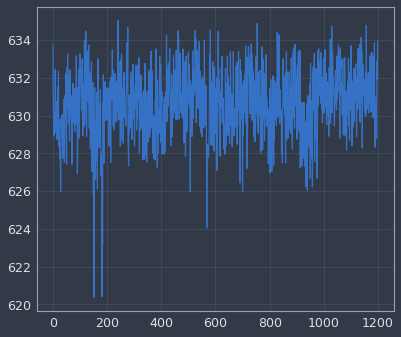

In [99]:
env_kwargs['n_envs'] = 800
episode_reward_sums += a3c_alg.train(n_episodes=200, **rl_alg_kwargs, **env_kwargs)
plt.plot(episode_reward_sums)
plt.show();

In [94]:
temp_model = a3c_alg.model_constructor()
temp_model.load_state_dict(a3c_alg.checkpoints[78])
temp_model.to(device=DEVICE)
temp_model.eval();

def model_wrapped(states):
    return temp_model.sample_action(states.unsqueeze(0)).squeeze(0)
    #return a3c_alg.model.sample_action(states.unsqueeze(0)).squeeze(0)

In [95]:
#(a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)).argmax() - len(initial_opponent_pool)
est_opp_skill = a3c_alg.opp_a / (a3c_alg.opp_a + a3c_alg.opp_b)
ranking = np.argsort(-est_opp_skill)
idx = 2
print(f'Opponent {ranking[idx]}, ranked {idx+1}, has an estimated win % of {est_opp_skill[ranking[idx]]:.3f}.')
print(f'Checkpoint #{ranking[idx] - len(a3c_alg.initial_opponent_pool)}, path: {a3c_alg.exp_folder}/{(ranking[idx] - len(a3c_alg.initial_opponent_pool)) * a3c_alg.checkpoint_freq}_cp.txt')
#np.argsort(-est_opp_skill)
est_opp_skill

Opponent 79, ranked 3, has an estimated win % of 0.567.
Checkpoint #78, path: /home/isaiah/GitHub/Kaggle/Santa_2020/runs/v4_contd/780_cp.txt


array([0.50081914, 0.48598948, 0.51816986, 0.53534363, 0.46065866,
       0.44087082, 0.51414301, 0.51720425, 0.52793261, 0.47424356,
       0.42742923, 0.47529614, 0.5254527 , 0.48897261, 0.52109964,
       0.47694271, 0.45016783, 0.47601805, 0.47159289, 0.51855141,
       0.49580052, 0.51869415, 0.53858207, 0.536909  , 0.52732594,
       0.46640437, 0.45991462, 0.46329322, 0.45704959, 0.46743117,
       0.46791895, 0.53791149, 0.49548694, 0.48558865, 0.42920494,
       0.49406646, 0.49618068, 0.47742934, 0.43402368, 0.54164681,
       0.44940406, 0.50318364, 0.48262202, 0.49925114, 0.52893415,
       0.54877225, 0.53945825, 0.56086373, 0.54719396, 0.47510184,
       0.42878113, 0.54572381, 0.5094365 , 0.55278641, 0.54164065,
       0.52252991, 0.42326271, 0.47107882, 0.40678069, 0.50733141,
       0.48909083, 0.52528071, 0.44195002, 0.47717234, 0.44998456,
       0.46451931, 0.51163051, 0.43091032, 0.46783486, 0.49800934,
       0.4827651 , 0.52969608, 0.57089156, 0.50188092, 0.52136

## Benchmark the model against a previous RL agent, and various hand-crafted algorithms

In [96]:
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', n_envs=4000, out_device=DEVICE)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v4-162'), 'new_model', 'a3c_agent_v4-162', n_envs=4000, out_device=DEVICE)

100%|██████████| 1999/1999 [00:46<00:00, 43.16it/s]


new_model -vs- a3c_agent_v3
Mean scores: 641.30 - 638.75
Match score: 2101 - 55 - 1844 (52.5% - 1.4% - 46.1%)


100%|██████████| 1999/1999 [00:48<00:00, 41.26it/s]


new_model -vs- a3c_agent_v4-162
Mean scores: 641.75 - 639.23
Match score: 2095 - 69 - 1836 (52.4% - 1.7% - 45.9%)


In [97]:
model.eval()
benchmark_env_kwargs = dict(
    n_envs=1000,
    out_device=DEVICE
)

## Against itself
va.run_vectorized_vs(model_wrapped, model_wrapped, 'new_model', 'new_model', **benchmark_env_kwargs)

## Previous best models
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v0'), 'new_model', 'a3c_agent_v0', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v1'), 'new_model', 'a3c_agent_v1', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v2'), 'new_model', 'a3c_agent_v2', **benchmark_env_kwargs)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v3'), 'new_model', 'a3c_agent_v3', n_envs=4000, out_device=DEVICE)
va.run_vectorized_vs(model_wrapped, va.SavedRLAgent('a3c_agent_v4-162'), 'new_model', 'a3c_agent_v4-162', n_envs=4000, out_device=DEVICE)

## Always 0 agent
#va.run_vectorized_vs(model_wrapped, va.AlwaysFirstAgent(), 'new_model', 'always_first', **benchmark_env_kwargs)

## Random agent
#va.run_vectorized_vs(model_wrapped, va.RandomAgent(), 'new_model', 'random_agent', **benchmark_env_kwargs)

## Basic thompson sampling
va.run_vectorized_vs(model_wrapped, va.BasicThompsonSampling(OBS_NORM), 'new_model', 'basic_thompson_sampling', **benchmark_env_kwargs)

## Pull vegas slot machines
va.run_vectorized_vs(model_wrapped, va.PullVegasSlotMachines(OBS_NORM), 'new_model', 'pull_vegas_slot_machines', **benchmark_env_kwargs)

100%|██████████| 1999/1999 [00:13<00:00, 143.15it/s]


new_model -vs- new_model
Mean scores: 638.77 - 640.44
Match score: 468 - 12 - 520 (46.8% - 1.2% - 52.0%)


100%|██████████| 1999/1999 [00:10<00:00, 194.02it/s]


new_model -vs- a3c_agent_v0
Mean scores: 652.14 - 630.10
Match score: 756 - 8 - 236 (75.6% - 0.8% - 23.6%)


100%|██████████| 1999/1999 [00:12<00:00, 161.52it/s]


new_model -vs- a3c_agent_v1
Mean scores: 645.86 - 630.47
Match score: 694 - 17 - 289 (69.4% - 1.7% - 28.9%)


100%|██████████| 1999/1999 [00:13<00:00, 143.46it/s]


new_model -vs- a3c_agent_v2
Mean scores: 642.78 - 637.56
Match score: 546 - 14 - 440 (54.6% - 1.4% - 44.0%)


100%|██████████| 1999/1999 [00:46<00:00, 42.63it/s]


new_model -vs- a3c_agent_v3
Mean scores: 641.32 - 638.37
Match score: 2156 - 44 - 1800 (53.9% - 1.1% - 45.0%)


100%|██████████| 1999/1999 [00:48<00:00, 40.95it/s]


new_model -vs- a3c_agent_v4-162
Mean scores: 642.92 - 639.64
Match score: 2146 - 70 - 1784 (53.7% - 1.8% - 44.6%)


100%|██████████| 1999/1999 [00:08<00:00, 243.49it/s]


new_model -vs- basic_thompson_sampling
Mean scores: 657.90 - 614.12
Match score: 928 - 2 - 70 (92.8% - 0.2% - 7.0%)


100%|██████████| 1999/1999 [00:08<00:00, 223.29it/s]


new_model -vs- pull_vegas_slot_machines
Mean scores: 650.41 - 613.26
Match score: 895 - 10 - 95 (89.5% - 1.0% - 9.5%)


## Benchmark the model against the checkpointed version

In [ ]:
model.eval()
benchmark_env_kwargs = dict(
    n_envs=1000,
    out_device=DEVICE
)

checkpointed_model = GraphNNA3C(**graph_nn_kwargs)
checkpointed_model.to(torch.device('cuda'))
checkpointed_model.load_state_dict(model_sd_checkpoint)
checkpointed_model.eval()

def checkpointed_model_wrapped(states):
    return checkpointed_model.sample_action(states.unsqueeze(0)).squeeze(0)

va.run_vectorized_vs(model_wrapped, checkpointed_model_wrapped, 'new_model', 'checkpointed_model', **benchmark_env_kwargs)

In [ ]:
temp_sd_checkpoint = model.state_dict()

## Visualize model parameter distributions

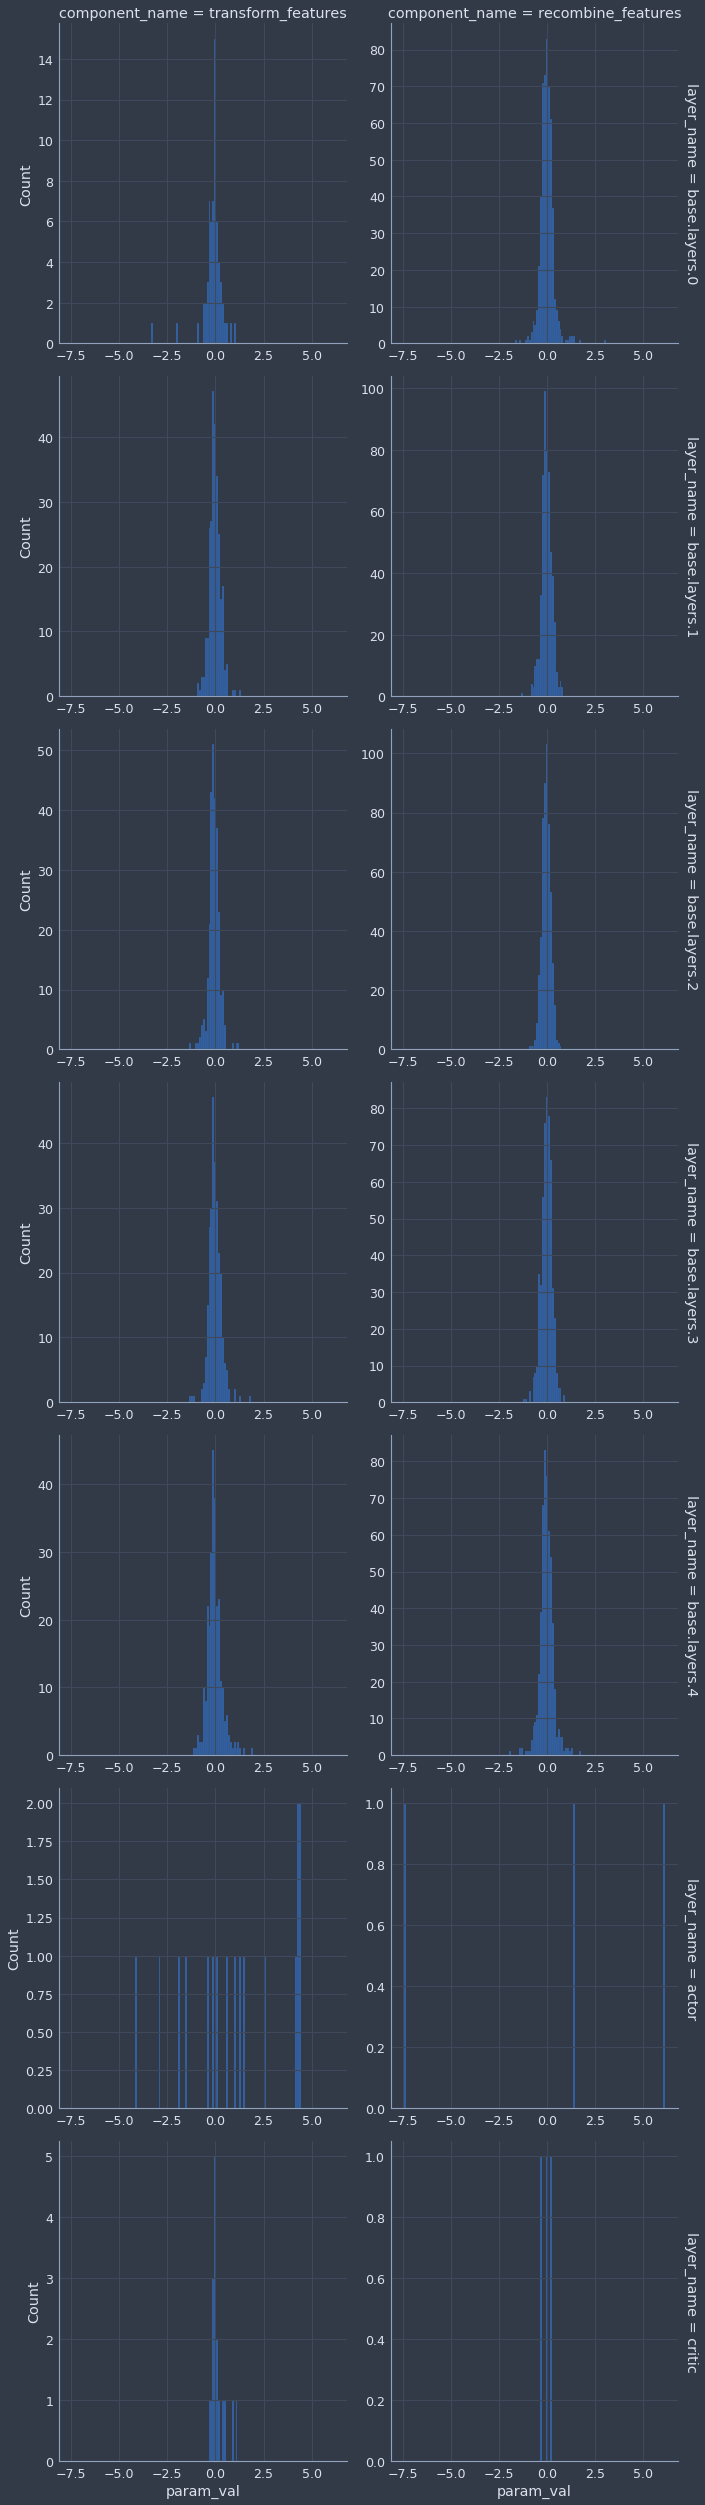

In [17]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in model.state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

In [ ]:
full_layer_name = []
layer_name = []
component_name = []
weight_or_bias = []
param_val = []
for key, val in GraphNNA3C(**graph_nn_kwargs).state_dict().items():
    if 'message_passing_mat' in key:
        pass
    else:
        for v in val.cpu().numpy().ravel():
            param_val.append(v)
            full_layer_name.append(key)
            key_split = key.split('.')
            if len(key_split) == 3:
                ln, pn, wob = key_split
            elif len(key_split) >= 4:
                ln = '.'.join(key_split[0:-2])
                pn, wob = key_split[-2:]
            else:
                raise RuntimeError(f'Unrecognized layer key: {key}')
            layer_name.append(ln)
            component_name.append(pn)
            weight_or_bias.append(wob)
params_df = pd.DataFrame(dict(
    full_layer_name = full_layer_name,
    layer_name = layer_name,
    component_name = component_name,
    weight_or_bias = weight_or_bias,
    param_val = param_val
))

sns.displot(
    params_df, x='param_val', col='component_name', row='layer_name',
    binwidth=0.1,
    #height=3,
    facet_kws=dict(margin_titles=True, sharex=False, sharey=False)
);

## Save the model state_dict as a serialized string

In [27]:
model.to('cpu')
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
    #'optimizer_state_dict': optimizer.state_dict()
})
serialized_string = base64.b64encode(state_dict_bytes)
with open('rl_agents/ss_temp.txt', 'w') as f:
    f.write(str(serialized_string))
model.to(device=DEVICE);

## Testing and debugging

In [19]:
s.shape

torch.Size([1, 2, 100, 3])

In [18]:
from scipy.stats import spearmanr, pearsonr

test_env = KaggleMABEnvTorchVectorized(n_players=2, decay_rate=0.97)
with torch.no_grad():
    test_env.reset()
    # Take n good actions
    for i in range(500):
        actions = test_env.thresholds.argmax(axis=-1)[:, None]
        s, _, _, _ = test_env.step(actions.repeat(1, test_env.n_players))
    logits, values = model(s[0,0].to(device=DEVICE)[None, None, :])
    logits = logits.cpu().numpy().squeeze()
    values = values.cpu().numpy().squeeze()
print()
print(logits)
print(values)
print(s[:,0].squeeze().t())
print(spearmanr(logits, test_env.thresholds.squeeze().cpu().numpy())[0],
      pearsonr(logits, test_env.thresholds.squeeze().cpu().numpy())[0])


[ -50.70728   343.18048  -360.98813  -184.58109   343.18048   343.18048
 -179.55315  -371.94223   343.18048  -101.76725  -289.71634   343.18048
  343.18033  -101.76725  -101.7673    343.1806    343.18048   -55.70023
 -423.23956   343.18048   343.18048  -144.07784  -483.9645   -132.49835
  343.18048  -284.71515  -214.44508   -36.317387  343.18033   343.1806
 -144.07787  -181.13568  -172.01115   330.54306  -392.00793   -42.726707
 -100.718575  343.18048  -232.7463   -184.58109  -182.04886   343.18048
 -209.41711  -139.44606  -169.4972    343.1806    343.18033  -309.7208
  343.18048   330.54306  -137.13019  -130.38986   343.18048   343.18048
  343.18048  -206.90314   343.18048   132.18704  -179.55313  -289.71637
 -141.76196   343.1806    343.18033  -222.74408   343.18048   343.18048
 -360.98813   343.18048   343.18048   343.18048  -174.52518  -166.98323
  343.18048   -50.707306 -164.46925   -50.707294 -130.38986  -416.65625
 -164.46925   343.1806   -209.41711  -100.9217    343.18048  -18

In [ ]:
child_layer_idx = -1
child_layer = list(model.children())[child_layer_idx]
print(child_layer.transform_features.weight.data, child_layer.transform_features.bias.data)
print(child_layer.recombine_features.weight.data, child_layer.recombine_features.bias.data)
print(model)
print(child_layer)

In [ ]:
test_env = KaggleMABEnvTorchVectorized(n_envs=3, n_players=2, decay_rate=0.97, env_device=torch.device('cpu'), out_device=DEVICE)
test_env.reset()
actions = torch.arange(6).view(3,2)
test_env.step(actions)
test_env.step(actions)
actions = torch.arange(1,7).view(3,2)
test_env.step(actions)
test_env.step(actions)
test_env.step(actions)

test = test_env.player_n_pulls.unsqueeze(3).expand(-1,-1,-1,2).transpose(1,3)
test = torch.cat([
    test[:,0,:,:].unsqueeze(1),
    test[:,0,:,[1,0]].unsqueeze(1)
], dim=1)
test[0,0]
test_env.player_rewards_sums

In [ ]:
# Simulated env rollouts with random policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cuda'))

for i in tqdm.trange(test_env.n_steps):
    actions = torch.randint(test_env.n_bandits, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
# Simulated env rollouts with omniscient optimal policy
test_env = KaggleMABEnvTorchVectorized(n_envs=1000, n_players=2, decay_rate=0.97, env_device=torch.device('cuda'), out_device=torch.device('cpu'))

for i in tqdm.trange(test_env.n_steps):
    actions = test_env.thresholds.argmax(axis=-1)[:, None]
    test_env.step(actions.repeat(1, test_env.n_players))
print(f'Mean of player rewards: {test_env.player_rewards_sums.sum(axis=-1).mean():.2f}, Standard deviation of player rewards: {test_env.player_rewards_sums.sum(axis=-1).std():.2f}')

In [ ]:
n_nodes = 10
activation_func = nn.ReLU()
layer_size = 64
layers = (
    [FullyConnectedGNNLayer(n_nodes, 1, layer_size, activation_func=activation_func)] +
    [FullyConnectedGNNLayer(n_nodes, layer_size, layer_size, activation_func=activation_func)] * 0 +
    [FullyConnectedGNNLayer(n_nodes, layer_size, 1, activation_func=activation_func)]
)
model = nn.Sequential(
    *layers
)
#model = FullyConnectedGNNLayer(n_nodes, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for i in tqdm.trange(10):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

test_batch_in = torch.rand((1, n_nodes, 1), dtype=torch.float).to('cuda')
print(test_batch_in)
print(F.softmax(model(test_batch_in), dim=1))
print(torch.topk(test_batch_in, k=k, dim=1).indices[:,k-1])
print(F.softmax(model(test_batch_in), dim=1).argmax(dim=1))

In [ ]:
for i in tqdm.trange(1000):
    train_batch_in = torch.rand((250, n_nodes, 1), dtype=torch.float).to('cuda')
    k = 2
    labels = torch.topk(train_batch_in, k=k, dim=1).indices[:,k-1]
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    
    accuracy = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
print(f'Loss: {loss:.2f}, Accuracy: {accuracy:.3f}')

In [ ]:
model = FullyConnectedGNNLayer(5, 1, 1, activation_func=nn.Identity())
model.train()
model.to('cuda')
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)

for i in tqdm.trange(10000):
    train_batch_in = torch.rand((1024, 5, 1), dtype=torch.float).to('cuda')
    train_batch_out = train_batch_in + train_batch_in.sum(dim=1, keepdims=True)
    
    optimizer.zero_grad()
    outputs = model(train_batch_in)
    loss = loss_func(outputs, train_batch_out)
    loss.backward()
    optimizer.step()
loss

In [ ]:
train_batch_in = torch.rand((2, 5, 1), dtype=torch.float).to('cuda')
print(train_batch_in)
print(train_batch_in + train_batch_in.sum(dim=1, keepdims=True))
print(model(train_batch_in))

## Deprecated

In [ ]:
# Loosely based on: https://github.com/MorvanZhou/pytorch-A3C
def a3c_vectorized_env(env, model, optimizer, n_episodes, batch_size,
                       gamma=0.9):
    model.to(device=DEVICE)
    model.train()
    episode_reward_sums = []
    
    for episode in tqdm.trange(n_episodes):
        buffer_s, buffer_a, buffer_r = [], [], []
        s, r, _, _ = env.reset()
        episode_reward_sums.append(r)
        step_count = 1
        while not env.done:
            # Batch size of 1 for inference
            a = model.sample_action(s.to(device=DEVICE).unsqueeze(0)).squeeze(0)
            next_s, r, done, _ = env.step(a)
            
            #print(s.shape, a.shape, r.shape)
            buffer_s.append(s)
            buffer_a.append(a)
            buffer_r.append(r)
            
            if step_count % batch_size == 0 or done:
                if done:
                    v_next_s = torch.zeros_like(buffer_r[-1])
                else:
                    _, v_next_s = model(next_s.to(device=DEVICE).unsqueeze(0))
                    v_next_s = v_next_s.detach().squeeze(0)
                v_next_s.to(device=DEVICE)
                
                buffer_v_target = []
                for r in buffer_r[::-1]:
                    v_next_s = r + gamma * v_next_s
                    buffer_v_target.append(v_next_s)
                buffer_v_target.reverse()
                
                loss = model.loss_func(
                    torch.stack(buffer_s).to(device=DEVICE),
                    torch.stack(buffer_a).to(device=DEVICE),
                    torch.stack(buffer_v_target).to(device=DEVICE)
                )
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                buffer_s, buffer_a, buffer_r = [], [], []
            s = next_s
            episode_reward_sums[-1] += r
            step_count += 1
        episode_reward_sums[-1] = episode_reward_sums[-1].mean()
    return episode_reward_sums

In [ ]:
class Kaggle_MAB_Env_Numpy_Vectorized():
    def __init__(self,
                 # Kaggle MAB env params
                 n_bandits=100, n_steps=1999, decay_rate=0.97, sample_resolution=100,
                 # Custom params
                 n_envs=1, n_players=2, reward_type=EVERY_STEP, remove_extra_dims=False):
        # Assert parameter conditions
        assert 0 <= decay_rate <= 1.
        assert reward_type in (END_OF_GAME, EVERY_STEP)
        if reward_type == END_OF_GAME:
            assert n_players >= 2
        else:
            assert n_players >= 1
        self.n_bandits = n_bandits
        self.n_steps = n_steps
        self.decay_rate = decay_rate
        self.sample_resolution = sample_resolution
        
        self.n_envs = n_envs
        self.n_players = n_players
        self.reward_type = reward_type
        self.remove_extra_dims = remove_extra_dims
        
        self.timestep = None
        self.orig_thresholds = None
        self.player_n_pulls = None
        self.player_rewards_sums = None
        self.reset()
    
    @property
    def thresholds(self):
        return self.orig_thresholds * (self.decay_rate ** self.player_n_pulls[:,0,:])
    
    def reset(self):
        self.timestep = 0
        self.orig_thresholds = np.random.randint(self.sample_resolution + 1, size=(self.n_envs, self.n_bandits)).astype(np.float32)
        self.player_n_pulls = np.zeros((self.n_envs, self.n_players, self.n_bandits))
        self.player_rewards_sums = np.zeros_like(self.player_n_pulls)
        
        rewards = np.zeros((self.n_envs, self.n_players))
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
        
    def step(self, actions):
        if self.remove_extra_dims:
            if type(actions) == int:
                actions = np.array([[actions]])
            else:
                actions = actions.reshape((self.n_envs, self.n_players))
        assert actions.shape == (self.n_envs, self.n_players), f'actions.shape was: {actions.shape}'
        assert not self.done
        self.timestep += 1
        
        # Compute agent rewards
        selected_thresholds = np.take_along_axis(self.thresholds, actions, axis=1)
        pull_rewards = np.random.randint(self.sample_resolution, size=selected_thresholds.shape) < selected_thresholds
        #pull_rewards = selected_thresholds / float(self.sample_resolution)
        
        # Update player_n_pulls and player_rewards_sums
        for env_idx, env_actions in enumerate(actions):
            for player_idx, pull_idx in enumerate(env_actions):
                self.player_n_pulls[env_idx, :, pull_idx] += 1
                self.player_rewards_sums[env_idx, player_idx, pull_idx] += pull_rewards[env_idx, player_idx]
        
        # Return (obs, reward, done) tuple
        if self.reward_type == END_OF_GAME:
            rewards = np.zeros_like(actions)
            if self.timestep == self.n_steps:
                rewards_sums = self.player_rewards_sums.sum(axis=2)
                winners = rewards_sums.argmax(axis=1)
                rewards[winners] = 1
        elif self.reward_type == EVERY_STEP:
            rewards = pull_rewards
        
        # State, reward, done, info_dict
        if self.remove_extra_dims:
            return self.get_obs().squeeze(), rewards.squeeze(), self.done, dict(thresholds=self.thresholds.squeeze())
        else:
            return self.get_obs(), rewards, self.done, dict(thresholds=self.thresholds)
    
    def get_obs(self):
        # TODO: Clearly do not return thresholds or orig_thresholds
        return np.stack([
            #np.broadcast_to(self.orig_thresholds[:, None, :] / self.sample_resolution, self.player_n_pulls.shape),
            self.player_n_pulls,
            self.player_rewards_sums
        ], axis=-1).astype(np.float32)
    
    @property
    def done(self):
        return self.timestep >= self.n_steps

In [ ]:
class FeedForwardNN_A3C(nn.Module):
    def __init__(self, in_features, n_bandits, activation_func=nn.ReLU()):
        super().__init__()
        self.in_features = in_features
        self.activation_func = activation_func
        layer_size = 128
        self.base = nn.Sequential(
            nn.Linear(self.in_features, layer_size),
            activation_func,
            nn.Linear(layer_size, layer_size),
            activation_func,
        )
        self.actor = nn.Linear(layer_size, n_bandits)
        self.critic = nn.Linear(layer_size, 1)
        
    def forward(self, states):
        in_shape = states.shape
        base_out = self.base(states.view(-1, self.in_features))
        return self.activation_func(self.actor(base_out)).view(in_shape[:-1]), self.critic(base_out).view(in_shape[:-2])
    
    def sample_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            probs = F.softmax(logits, dim=-1)
            batch_size, n_envs, n_players, n_bandits = probs.shape
            m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
            return m.sample().view(batch_size, n_envs, n_players)
    
    def choose_best_action(self, states):
        with torch.no_grad():
            logits, _ = self.forward(states)
            return logits.argmax(dim=-1)
        
    def loss_func(self, states, actions, v_t):
        #print(f'states.shape: {states.shape}, actions.shape: {actions.shape}, v_t.shape: {v_t.shape}')
        logits, values = self.forward(states)
        
        #print(f'logits.shape: {logits.shape}, values.shape: {values.shape}')
        td = v_t - values
        critic_loss = td.pow(2).view(-1)
        
        probs = F.softmax(logits, dim=-1)
        batch_size, n_envs, n_players, n_bandits = probs.shape
        m = distributions.Categorical(probs.view(batch_size * n_envs * n_players, n_bandits))
        #print(f'm.log_prob(actions.view(batch_size * n_envs * n_players)).shape: {m.log_prob(actions.view(batch_size * n_envs * n_players)).shape}, td.shape: {td.shape}')
        actor_loss = -(m.log_prob(actions.view(-1)) * td.detach().view(-1))
        total_loss = (critic_loss + actor_loss).mean()
        return total_loss